## Packages

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Funciones gráficas

In [2]:
def plot_fai_and_flare_lines(df_combined, df_fai_assoc, df_fai_all, df_flare_data, 
                             flare_start_time, flare_end_time, graphics_dir,
                             freq_ticks='10min', ymin=1e-9, ymax=1e-4,
                             figsize=(13, 5), save_plot=True, annotate_counts=False):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for:
      - All FAI candidates (dark gray)
      - True FAIs (pink)
      - Associated FAIs (red dashed)
      - Flare start, peak, end times (green, blue, orange)
    
    Parameters
    ----------
    df_combined : pd.DataFrame
        Main GOES time series with 'date', 'xrsa', 'xrsb'.
    df_fai_assoc : pd.DataFrame
        FAI dataframe with flags FAI_true and Associated_Flare.
    df_fai_all : pd.DataFrame
        All candidate FAIs (before filtering).
    df_flare_data : pd.DataFrame
        Flare catalog with StartTime, PeakTime, EndTime.
    flare_start_time, flare_end_time : str or datetime
        Interval to plot.
    graphics_dir : str
        Output folder for saved plot.
    freq_ticks : str, optional
        Major tick frequency (e.g., '10min').
    ymin, ymax : float, optional
        Y-axis log scale limits.
    figsize : tuple, optional
        Figure size in inches.
    save_plot : bool, optional
        Whether to save the plot to disk.
    """

    # Convert times
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)

    print(f"Buscando datos entre: {flare_start_time} y {flare_end_time}")

    # Ensure datetime columns
    for df, col in [(df_combined, 'date'),
                    (df_fai_assoc, 'date'),
                    (df_fai_all, 'date')]:
        df[col] = pd.to_datetime(df[col])

    for col in ['StartTime', 'PeakTime', 'EndTime']:
        df_flare_data[col] = pd.to_datetime(df_flare_data[col])

    # Filter data within interval
    df_plot = df_combined[(df_combined['date'] >= flare_start_time) & 
                          (df_combined['date'] <= flare_end_time)].copy()
    df_fai_interval = df_fai_assoc[(df_fai_assoc['date'] >= flare_start_time) & 
                                   (df_fai_assoc['date'] <= flare_end_time)].copy()
    df_fai_all_interval = df_fai_all[(df_fai_all['date'] >= flare_start_time) & 
                                     (df_fai_all['date'] <= flare_end_time)].copy()

    # Print basic info
    print(f"Datos en df_plot: {len(df_plot)}, FAI_assoc: {len(df_fai_interval)}, FAI_all: {len(df_fai_all_interval)}")

    if df_plot.empty:
        print("⚠️ No hay datos de GOES en el rango seleccionado.")
        return

    # Configure plot style
    plt.rcParams.update({
        "axes.titlesize": 16, "axes.labelsize": 16,
        "xtick.labelsize": 15, "ytick.labelsize": 15,
        "legend.fontsize": 13
    })

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    x_vals = np.arange(len(df_plot))

    # Plot XRS A & B
    ax.plot(x_vals, df_plot['xrsa'], label='XRS A', color='blue', linewidth=1)
    ax.plot(x_vals, df_plot['xrsb'], label='XRS B', color='red', linewidth=1)
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel(f"Time [UTC] – {flare_start_time:%d %b %Y}")
    ax.set_title(f'XRS A and B with FAI and Flare Times\n{flare_start_time:%Y-%m-%d %H:%M} to {flare_end_time:%H:%M}')
    ax.grid(True, alpha=0.3)

    # ---------- Configure X ticks ----------
    major_times = pd.date_range(start=flare_start_time.ceil('10min'),
                                end=flare_end_time, freq=freq_ticks)
    major_indices = np.searchsorted(df_plot['date'].values, major_times.values)
    major_labels = [t.strftime('%H:%M') for t in major_times]
    minor_times = pd.date_range(start=flare_start_time.ceil('1min'),
                                end=flare_end_time, freq='1min')
    minor_indices = np.searchsorted(df_plot['date'].values, minor_times.values)

    ax.set_xticks(major_indices)
    ax.set_xticklabels(major_labels)
    ax.set_xticks(minor_indices, minor=True)

    # ---------- Plot all FAI candidates (dark gray) ----------
    for i, fai_time in enumerate(df_fai_all_interval['date']):
        idx = np.searchsorted(df_plot['date'].values, np.datetime64(fai_time))
        ax.axvline(x=idx, color='dimgray', linestyle='-', linewidth=1.5, alpha=0.7,
                   label='FAI Candidate' if i == 0 else "")

    # ---------- Plot FAI_true (pink) ----------
    fai_true_times = df_fai_interval.loc[df_fai_interval['FAI_true'] == True, 'date']
    for i, fai_time in enumerate(fai_true_times):
        idx = np.searchsorted(df_plot['date'].values, np.datetime64(fai_time))
        ax.axvline(x=idx, color='#FF69B4', linestyle='-', linewidth=1.5, alpha=0.7,
                   label='FAI Alert' if i == 0 else "")

    # ---------- Plot Associated_Flare (red dashed) ----------
    associated_times = df_fai_interval.loc[df_fai_interval['Associated_Flare'] == True, 'date']
    for i, assoc_time in enumerate(associated_times):
        idx = np.searchsorted(df_plot['date'].values, np.datetime64(assoc_time))
        # Guiones de 10 puntos con espacio de 5 puntos
        ax.axvline(x=idx, color='red', linestyle=(0, (6, 6)), linewidth=1.5, alpha=0.7,
        #ax.axvline(x=idx, color='red', linestyle='--', linewidth=1.5, alpha=0.7,
                   label='Associated Flare' if i == 0 else "")

    # ---------- Flare information ----------
    flares_in_interval = df_flare_data[
        (df_flare_data['PeakTime'] >= flare_start_time) & 
        (df_flare_data['PeakTime'] <= flare_end_time)
    ]
    print(f"Fulguraciones en intervalo: {len(flares_in_interval)}")

    num_fai_candidates = len(df_fai_all_interval)
    num_fai_true = df_fai_interval[df_fai_interval['FAI_true']].shape[0]
    num_fai_associated = df_fai_interval[df_fai_interval['Associated_Flare']].shape[0]

    print(f"FAI candidatos en el intervalo: {num_fai_candidates}")
    print(f"FAI verdaderos en el intervalo: {num_fai_true}")
    print(f"FAI asociados a flares en el intervalo: {num_fai_associated}")

    # Anotación sobre la gráfica si se desea
    if annotate_counts:
        textstr = (f"Flares: {len(flares_in_interval)}\n"
                   f"FAI candidates: {num_fai_candidates}\n"
                   f"FAI true: {num_fai_true}\n"
                   f"FAI asociated: {num_fai_associated}")
        ax.text(0.02, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.5))
        

    # ---------- Plot flare start/peak/end ----------
    for i, (_, row) in enumerate(flares_in_interval.iterrows()):
        for label, col, color, style, lw in [
            ('Flare Start', 'StartTime', 'green', (0, (5, 3)), 2),
            ('Flare Peak', 'PeakTime', 'blue', (0, (5, 3)), 2),
            ('Flare End', 'EndTime', 'orange', '--', 3)
        ]:
            t = row[col]
            if flare_start_time <= t <= flare_end_time:
                idx = np.searchsorted(df_plot['date'].values, np.datetime64(t))
                ax.axvline(x=idx, color=color, linestyle=style, linewidth=lw, alpha=0.8,
                           label=label if i == 0 else "")

        # annotate class at peak
        if 'Class' in row and pd.notna(row['PeakTime']):
            peak_idx = np.searchsorted(df_plot['date'].values, np.datetime64(row['PeakTime']))
            ax.annotate(row['Class'], xy=(peak_idx, ymin * 5), xytext=(peak_idx + 1, ymin * 15),
                        fontsize=9, color='darkblue', ha='left', va='center',
                        bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="darkblue", lw=1, alpha=0.8),
                        arrowprops=dict(arrowstyle='->', color='darkblue', lw=1, alpha=0.7))

    # ---------- Legend and layout ----------
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")
    fig.tight_layout()

    # ---------- Save or show ----------
    if save_plot:
        os.makedirs(graphics_dir, exist_ok=True)
        output_name = f"FAI_{flare_start_time:%Y%m%d_%H%M}_{flare_end_time:%H%M}.png"
        output_path = os.path.join(graphics_dir, output_name)
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"✅ Gráfica guardada en: {output_path}")

    plt.show()


##

## Parameters

In [3]:
n=185
# nuevo número de días
new_n = 148
fecha_actual = "2025-11-11"

window_minutes=30
fai_temp_range = (7, 14)
fai_em_threshold = 0.005
date_column = "date"
duration = True
FAI_duration = 3
filter_flare_coincidence = True
method = "filtered" # "all", "true" o "filtered"

## Valid Data 

In [4]:
output_dir = f"Data_for_{n}_days"

# Path of cleaned data in csv
csv_path_full_valid = f"{output_dir}/df_full_{new_n}_valid.csv"
# Path of valid flares: 
csv_path_flares = f"{output_dir}/df_flares_{new_n}_valid.csv"
# Path of df_full
csv_path_full = f"{output_dir}/all_df_full_{n}.csv"

# Verificar existencia de archivos y avisar
if not os.path.exists(csv_path_full_valid):
    print(f"⚠️ No se encontró el archivo GOES: {csv_path_full_valid}")
else:
    print(f"✅ Archivo GOES encontrado: {csv_path_full_valid}")

if not os.path.exists(csv_path_flares):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_flares}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_flares}")

if not os.path.exists(csv_path_full):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_full}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_full}")



✅ Archivo GOES encontrado: Data_for_185_days/df_full_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/df_flares_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/all_df_full_185.csv


In [5]:
df_full_valid = pd.read_csv(csv_path_full_valid)
df_flares_valid = pd.read_csv(csv_path_flares)
df_full = pd.read_csv(csv_path_full)

## Data_method

In [6]:

analysis_dir = os.path.join(f"Analysis_FAI")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_dir ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_dir }")
else:
    os.makedirs(analysis_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_dir}")

# Crear subcarpeta para guardar resultados de análisis
analysis_esp = os.path.join(analysis_dir, f"Analysis_FAI_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_esp ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_esp }")
else:
    os.makedirs(analysis_esp , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_esp}")

# Path of anticipation_time
csv_path_anticipation_time = f"{analysis_esp}/df_anticipation_time_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_all
csv_path_fai_all = f"{analysis_esp}/df_fai_all_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_selected
csv_path_fai_selected = f"{analysis_esp}/df_fai_{method}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of df_fai_assoc
csv_path_fai_assoc = f"{analysis_esp}/df_fai_assoc2_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

if not os.path.exists(csv_path_anticipation_time):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_anticipation_time}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_anticipation_time}")
if not os.path.exists(csv_path_fai_all):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_all}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_all}")
if not os.path.exists(csv_path_fai_selected):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_selected}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_selected}")
if not os.path.exists(csv_path_fai_assoc):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_assoc}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_assoc}")



⚠️ La carpeta de análisis ya existía: Analysis_FAI
⚠️ La carpeta de análisis ya existía: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_anticipation_time_filtered_(W_30)_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_all_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_filtered_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_assoc2_filtered_(W_30)_T7-14_EM0.005_dur3min.csv


In [7]:
df_anticipation_time = pd.read_csv(csv_path_anticipation_time)
df_fai_all = pd.read_csv(csv_path_fai_all)
df_fai_selected = pd.read_csv(csv_path_fai_selected)
df_fai_assoc = pd.read_csv(csv_path_fai_assoc)

## Carpeta para FlarebyFlare

In [8]:
analysis_dir = os.path.join(f"Analysis_FAI")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_dir ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_dir }")
else:
    os.makedirs(analysis_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_dir}")

# Crear subcarpeta para guardar resultados de análisis
analysis_esp = os.path.join(analysis_dir, f"Analysis_FAI_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_esp ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_esp }")
else:
    os.makedirs(analysis_esp , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_esp}")

folder = f"FlarebyFlare_{method}_W{window_minutes}min"

# Crear subcarpeta para guardar resultados de análisis
FlarebyFlare_dir = os.path.join(analysis_esp, folder)
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(FlarebyFlare_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {FlarebyFlare_dir}")
else:
    os.makedirs(FlarebyFlare_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {FlarebyFlare_dir}")




⚠️ La carpeta de análisis ya existía: Analysis_FAI
⚠️ La carpeta de análisis ya existía: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min
📁 Carpeta de análisis creada: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min


## Info dfs

In [9]:
df_full_valid["date"] = pd.to_datetime(df_full_valid["date"])
df_flares_valid["StartTime"] = pd.to_datetime(df_flares_valid["StartTime"])
df_flares_valid["PeakTime"]  = pd.to_datetime(df_flares_valid["PeakTime"])
df_flares_valid["EndTime"]   = pd.to_datetime(df_flares_valid["EndTime"])
df_anticipation_time["StartTime"] = pd.to_datetime(df_anticipation_time["StartTime"])
df_anticipation_time["PeakTime"]  = pd.to_datetime(df_anticipation_time["PeakTime"])
df_anticipation_time["EndTime"]   = pd.to_datetime(df_anticipation_time["EndTime"])
df_fai_selected["date"] = pd.to_datetime(df_fai_selected["date"])

## Búsqueda individual

In [10]:
pd.set_option('display.max_columns', None)
df_fai_assoc.iloc[:3]

,GOES_ID,date,day,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,FAI_alert,FAI_true,delta_min,group_id,duration_from_start,Time_FAI,Associated_Flare,Flare_ID,F_StartTime,F_PeakTime,F_EndTime,F_Class,F_ClassLetter,F_ClassNumber,F_ClassGroup,F_Observatory,F_StartPeak,F_PeakEnd,F_StartEnd,Association_Type,Time_to_flare,FAI_to_start,FAI_to_peak,FAI_to_end
0,GOES_10,2000-06-06 00:17:00,2000-06-06,GOES-16,4.194724e-08,0.000001,2.585677e-08,2.906549e-07,11.058271,1.937464e+47,9.953444,5.260247e+47,0.019375,0.052602,True,True,1.0,3,2.0,2000-06-06 00:17:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,StartTime,11.0,11.0,26.0,38.0
1,GOES_13,2000-06-06 00:25:00,2000-06-06,GOES-16,4.753495e-08,0.000001,8.936986e-09,1.561961e-07,9.086959,1.344306e+47,8.010274,4.128245e+47,0.013443,0.041282,True,True,1.0,4,2.0,2000-06-06 00:25:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,StartTime,3.0,3.0,18.0,30.0
2,GOES_14,2000-06-06 00:26:00,2000-06-06,GOES-16,5.612609e-08,0.000001,1.455322e-08,2.010820e-07,10.094641,1.496619e+47,8.974755,4.320921e+47,0.014966,0.043209,True,True,1.0,4,3.0,2000-06-06 00:26:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,StartTime,2.0,2.0,17.0,29.0


In [11]:
df_anticipation_time.sort_values(by="FAIalerts_W", ascending=False)[:2]

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,PeakEnd,StartEnd,day,FAIalerts_W,FAIalerts_WStart,FAIalerts_WPeak,FAIalerts_StartPeak,FAIalerts_PeakEnd,FAIalerts_startEnd,AnticipationStart,AnticipationPeak,Peak_to_lastFAI,Time_since_prev_flare_end,Time_since_prev_flare_peak,RelAnticipation_Peak,RelAnticipation_Start
973,Flare_20230807_1383,2023-08-07 15:30:00,2023-08-07 16:27:00,2023-08-07 16:36:00,M1.0,M,1.0,M1-4.9,GOES,57.0,9.0,66.0,2023-08-07,36,7,36,29,0,29,21.0,78.0,22.0,101.0,109.0,1.368421,0.368421
204,Flare_20020723_318,2002-07-23 07:22:00,2002-07-23 08:14:00,2002-07-23 08:33:00,C3.7,C,3.7,C1-4.9,GOES,52.0,19.0,71.0,2002-07-23,32,4,32,28,0,28,16.0,68.0,1.0,NaN,NaN,1.307692,0.307692


## Analysis flare by flare

Buscando datos entre: 2006-12-13 18:10:00 y 2006-12-13 20:00:00
Datos en df_plot: 111, FAI_assoc: 2, FAI_all: 6
Fulguraciones en intervalo: 2
FAI candidatos en el intervalo: 6
FAI verdaderos en el intervalo: 2
FAI asociados a flares en el intervalo: 2
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20061213_1810_2000.png


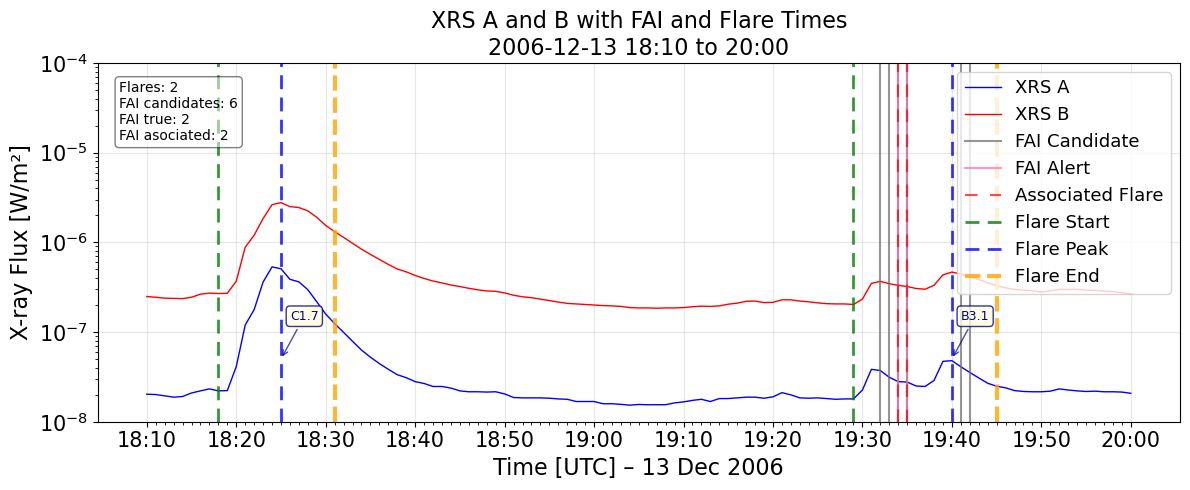

In [13]:

plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2006-12-13 18:10:00",
                             flare_end_time="2006-12-13 20:00:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='10min',
                             ymin=1e-8, ymax=1e-4,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)

## Flares Class X sin alertas

Buscando datos entre: 2024-05-14 16:00:00 y 2024-05-14 18:20:00
Datos en df_plot: 141, FAI_assoc: 11, FAI_all: 16
Fulguraciones en intervalo: 2
FAI candidatos en el intervalo: 16
FAI verdaderos en el intervalo: 11
FAI asociados a flares en el intervalo: 7
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20240514_1600_1820.png


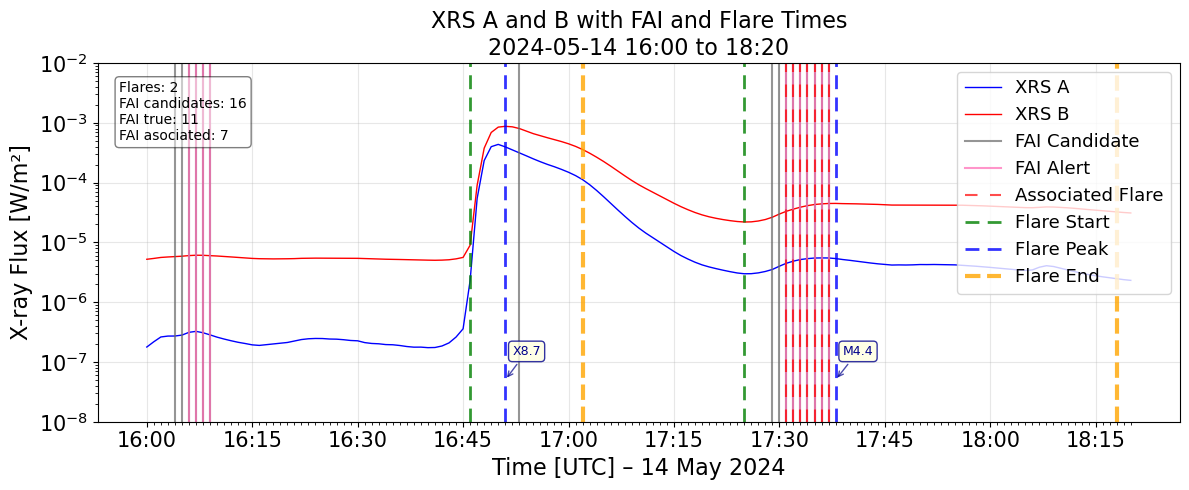

In [19]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2024-05-14 16:00:00",
                             flare_end_time="2024-05-14 18:20:000", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='15min',
                             ymin=1e-8, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)

Buscando datos entre: 2003-11-02 15:00:00 y 2003-11-02 18:30:00
Datos en df_plot: 211, FAI_assoc: 7, FAI_all: 14


Fulguraciones en intervalo: 1
FAI candidatos en el intervalo: 14
FAI verdaderos en el intervalo: 7
FAI asociados a flares en el intervalo: 0
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20031102_1500_1830.png


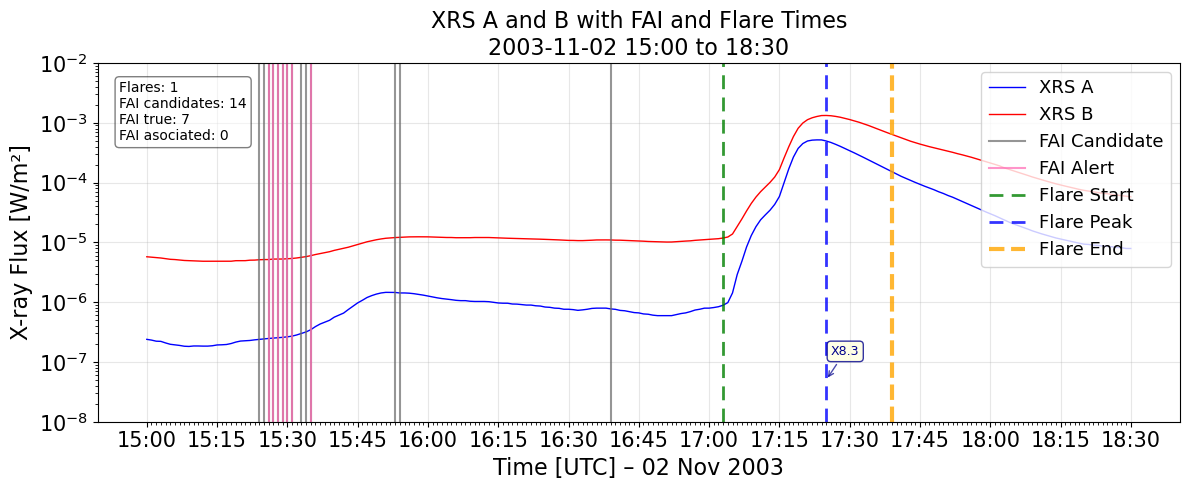

In [22]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2003-11-02 15:00:00",
                             flare_end_time="2003-11-02 18:30:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='15min',
                             ymin=1e-8, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)


Buscando datos entre: 2000-07-14 09:10:00 y 2000-07-14 11:00:00
Datos en df_plot: 111, FAI_assoc: 22, FAI_all: 28


Fulguraciones en intervalo: 2
FAI candidatos en el intervalo: 28
FAI verdaderos en el intervalo: 22
FAI asociados a flares en el intervalo: 22
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20000714_0910_1100.png


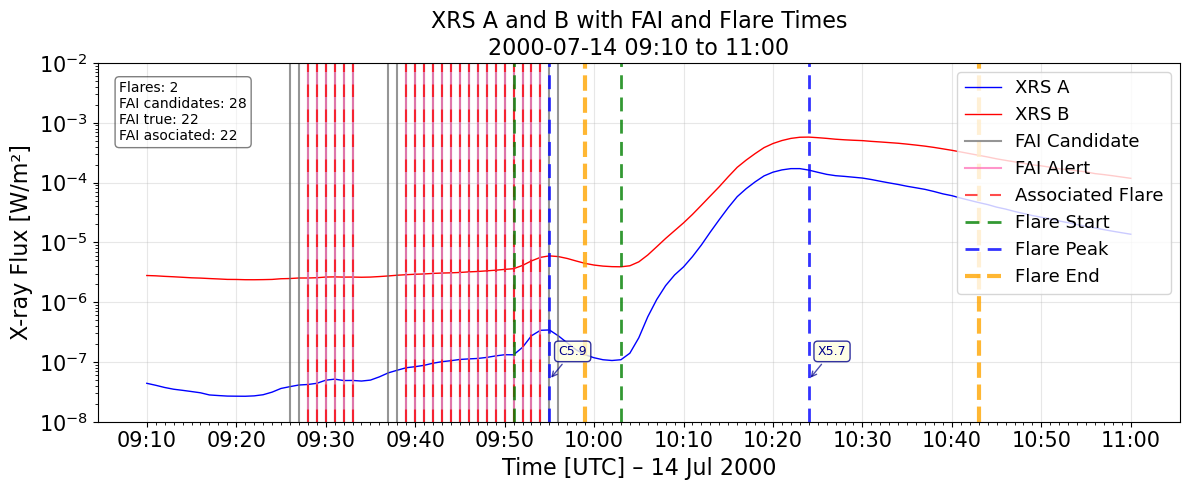

In [24]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2000-07-14 09:10:00",
                             flare_end_time="2000-07-14 11:00:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='10min',
                             ymin=1e-8, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)

Buscando datos entre: 2012-03-07 00:00:00 y 2012-03-07 01:00:00
Datos en df_plot: 61, FAI_assoc: 0, FAI_all: 1
Fulguraciones en intervalo: 1
FAI candidatos en el intervalo: 1
FAI verdaderos en el intervalo: 0
FAI asociados a flares en el intervalo: 0
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20120307_0000_0100.png


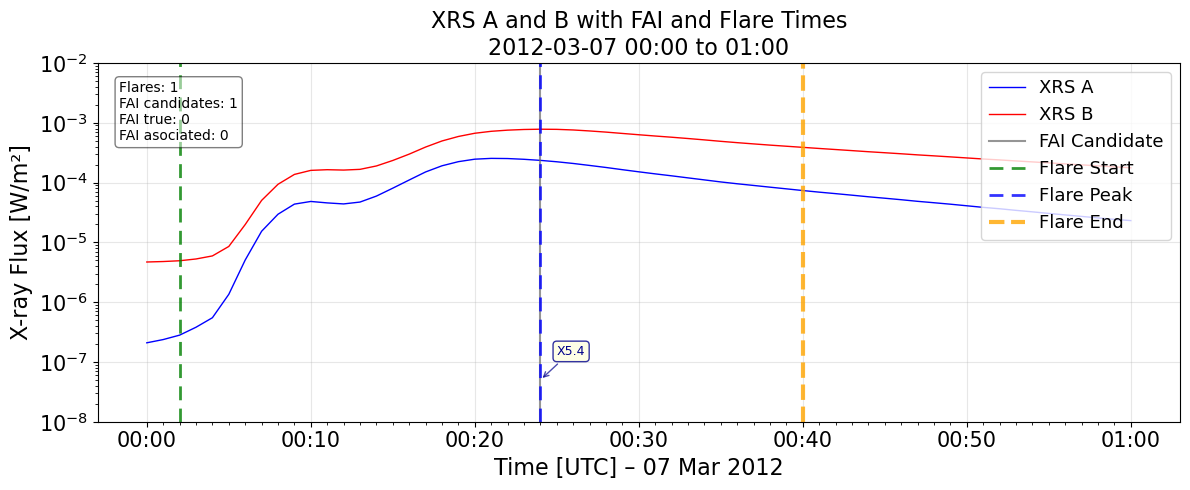

In [26]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2012-03-07 00:00:00",
                             flare_end_time="2012-03-07 01:00:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='10min',
                             ymin=1e-8, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)

Buscando datos entre: 2003-10-23 06:00:00 y 2003-10-23 09:30:00
Datos en df_plot: 211, FAI_assoc: 6, FAI_all: 15
Fulguraciones en intervalo: 2
FAI candidatos en el intervalo: 15
FAI verdaderos en el intervalo: 6
FAI asociados a flares en el intervalo: 0


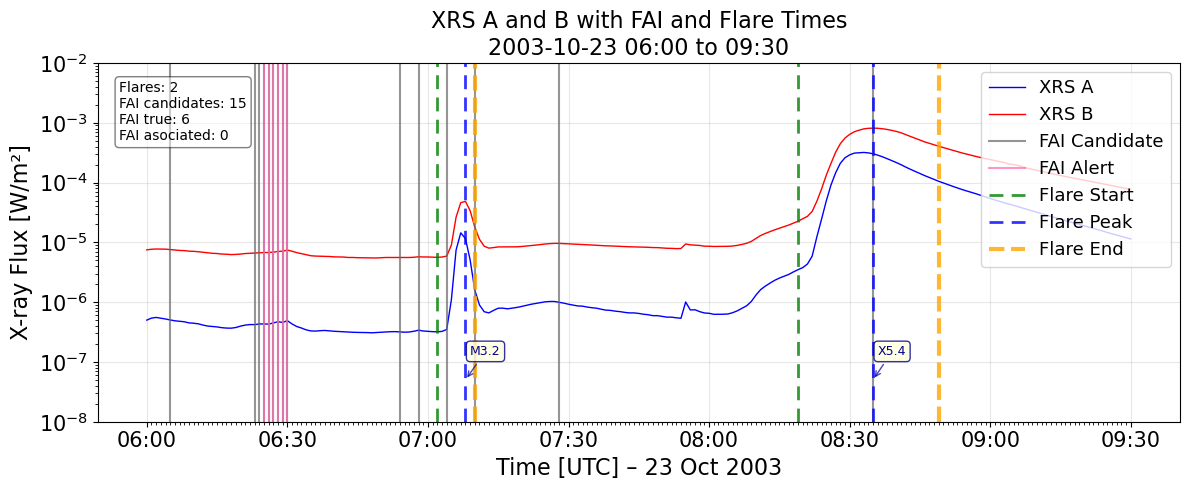

In [36]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2003-10-23 06:0:00",
                             flare_end_time="2003-10-23 09:30:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='30min',
                             ymin=1e-8, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=False,
                             annotate_counts=True)

Buscando datos entre: 2023-12-31 20:00:00 y 2023-12-31 23:10:00
Datos en df_plot: 191, FAI_assoc: 3, FAI_all: 6


Fulguraciones en intervalo: 1
FAI candidatos en el intervalo: 6
FAI verdaderos en el intervalo: 3
FAI asociados a flares en el intervalo: 0
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20231231_2000_2310.png


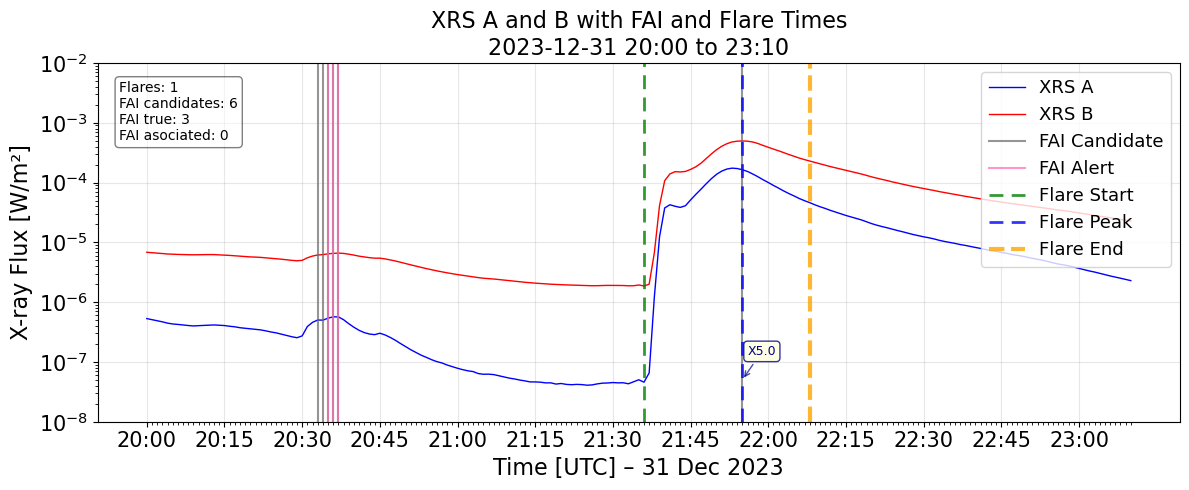

In [39]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2023-12-31 20:00:00",
                             flare_end_time="2023-12-31 23:10:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='15min',
                             ymin=1e-8, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)

Buscando datos entre: 2014-02-25 00:00:00 y 2014-02-25 02:00:00
Datos en df_plot: 121, FAI_assoc: 0, FAI_all: 4


Fulguraciones en intervalo: 1
FAI candidatos en el intervalo: 4
FAI verdaderos en el intervalo: 0
FAI asociados a flares en el intervalo: 0
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20140225_0000_0200.png


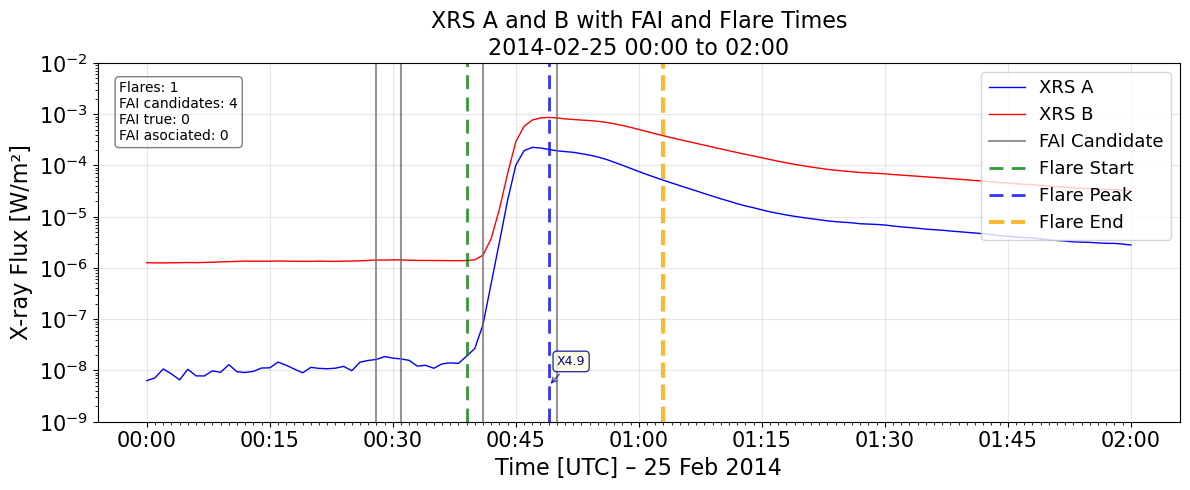

In [42]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2014-02-25 00:00:00",
                             flare_end_time="2014-02-25 02:00:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='15min',
                             ymin=1e-9, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)

Buscando datos entre: 2004-07-16 12:20:00 y 2004-07-16 14:20:00
Datos en df_plot: 121, FAI_assoc: 3, FAI_all: 8
Fulguraciones en intervalo: 2
FAI candidatos en el intervalo: 8
FAI verdaderos en el intervalo: 3
FAI asociados a flares en el intervalo: 3
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20040716_1220_1420.png


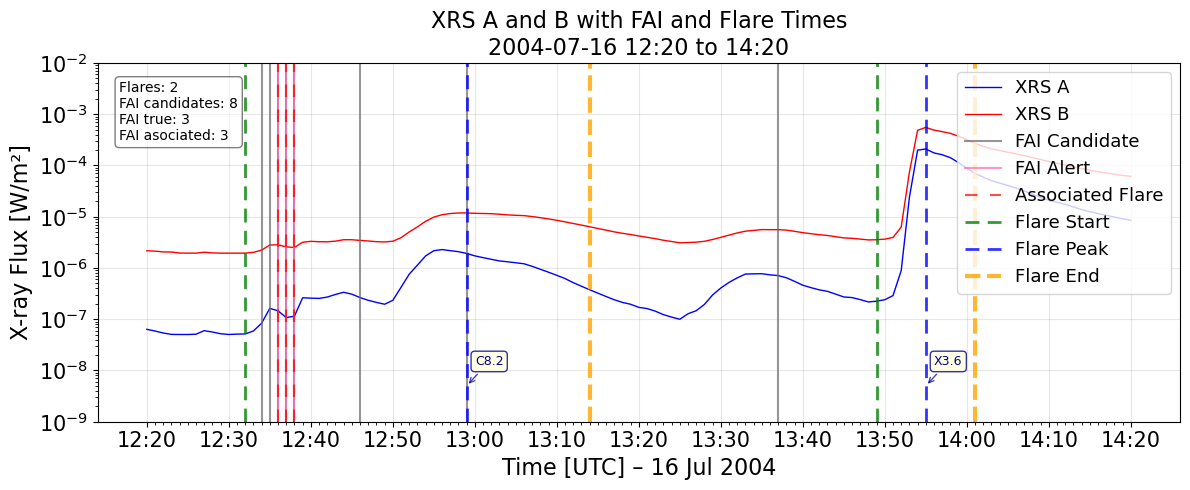

In [51]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2004-07-16 12:20:00",
                             flare_end_time="2004-07-16 14:20:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='10min',
                             ymin=1e-9, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)

Buscando datos entre: 2006-12-13 01:30:00 y 2006-12-13 03:20:00
Datos en df_plot: 111, FAI_assoc: 0, FAI_all: 4
Fulguraciones en intervalo: 1
FAI candidatos en el intervalo: 4
FAI verdaderos en el intervalo: 0
FAI asociados a flares en el intervalo: 0
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20061213_0130_0320.png


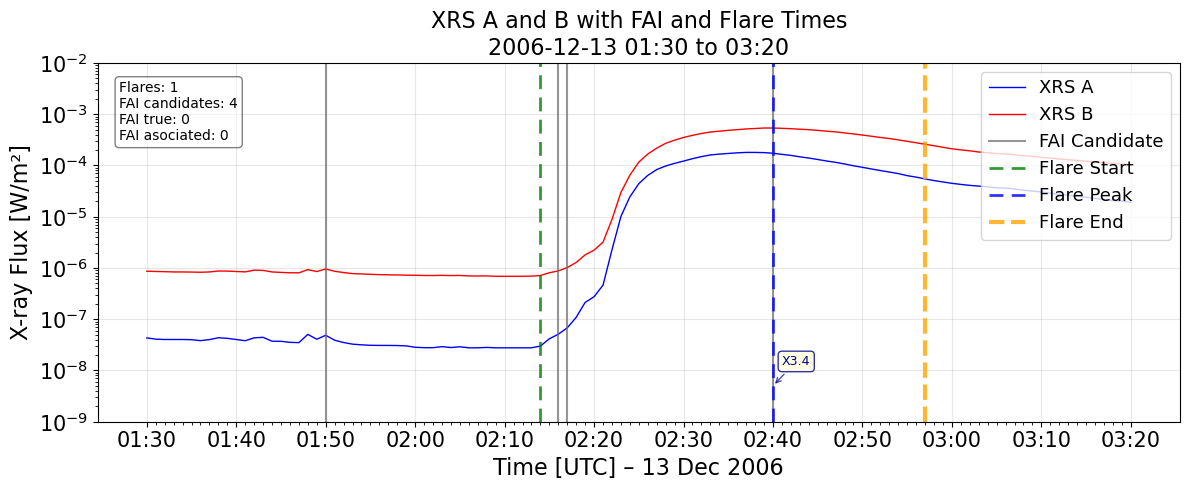

In [57]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2006-12-13 01:30:00",
                             flare_end_time="2006-12-13 03:20:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='10min',
                             ymin=1e-9, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)

Buscando datos entre: 2024-05-15 07:00:00 y 2024-05-15 09:00:00
Datos en df_plot: 121, FAI_assoc: 14, FAI_all: 23
Fulguraciones en intervalo: 4
FAI candidatos en el intervalo: 23
FAI verdaderos en el intervalo: 14
FAI asociados a flares en el intervalo: 14
✅ Gráfica guardada en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FlarebyFlare_filtered_W30min/FAI_20240515_0700_0900.png


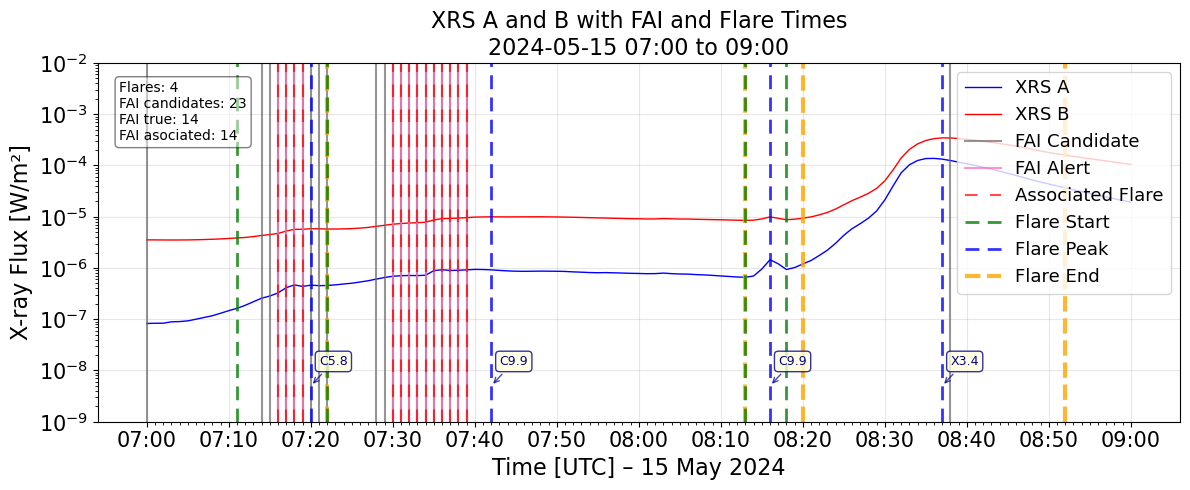

In [59]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2024-05-15 07:00:00",
                             flare_end_time="2024-05-15 09:00:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='10min',
                             ymin=1e-9, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=True,
                             annotate_counts=True)

Buscando datos entre: 2002-07-20 19:00:00 y 2002-07-20 22:00:00
Datos en df_plot: 181, FAI_assoc: 9, FAI_all: 23
Fulguraciones en intervalo: 1
FAI candidatos en el intervalo: 23
FAI verdaderos en el intervalo: 9
FAI asociados a flares en el intervalo: 0


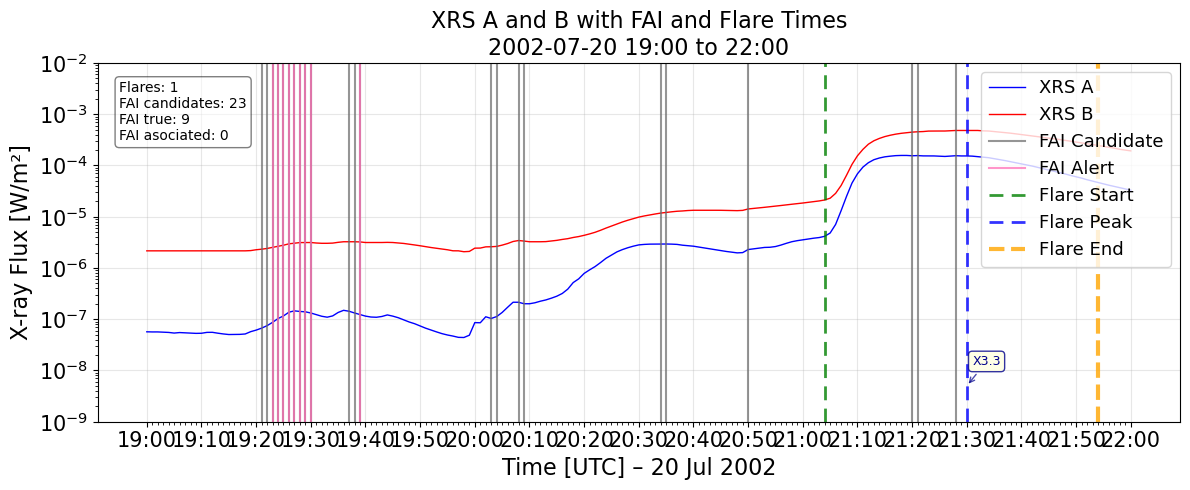

In [61]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2002-07-20 19:00:00",
                             flare_end_time="2002-07-20 22:00:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='10min',
                             ymin=1e-9, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=False,
                             annotate_counts=True)

Buscando datos entre: 2003-11-04 15:00:00 y 2003-11-04 20:30:00
Datos en df_plot: 331, FAI_assoc: 10, FAI_all: 25


Fulguraciones en intervalo: 1
FAI candidatos en el intervalo: 25
FAI verdaderos en el intervalo: 10
FAI asociados a flares en el intervalo: 0


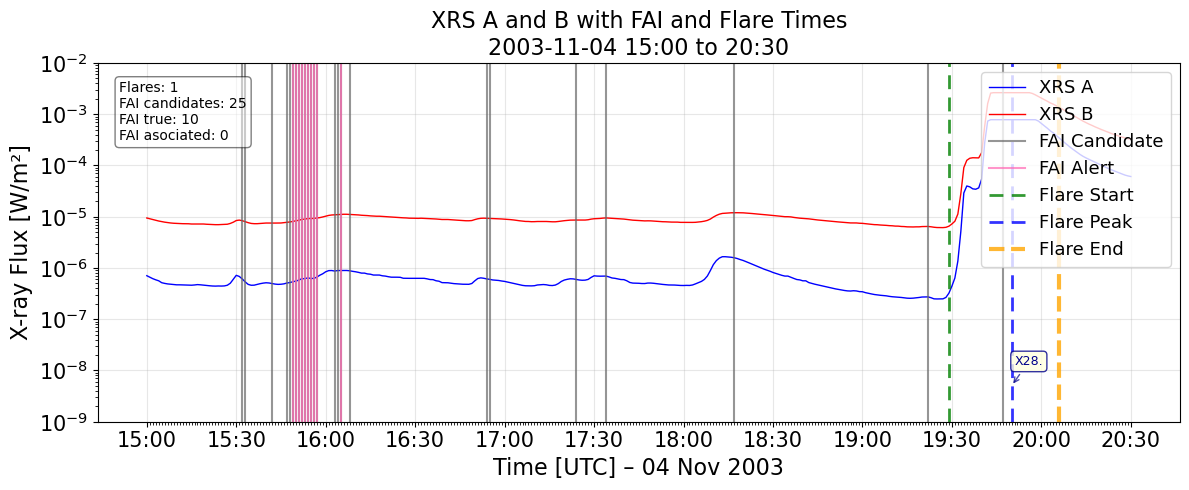

In [65]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2003-11-04 15:00:00",
                             flare_end_time="2003-11-04 20:30:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='30min',
                             ymin=1e-9, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=False,
                             annotate_counts=True)

Buscando datos entre: 2024-05-15 10:00:00 y 2024-05-15 16:00:00
Datos en df_plot: 361, FAI_assoc: 17, FAI_all: 26


Fulguraciones en intervalo: 3
FAI candidatos en el intervalo: 26
FAI verdaderos en el intervalo: 17
FAI asociados a flares en el intervalo: 0


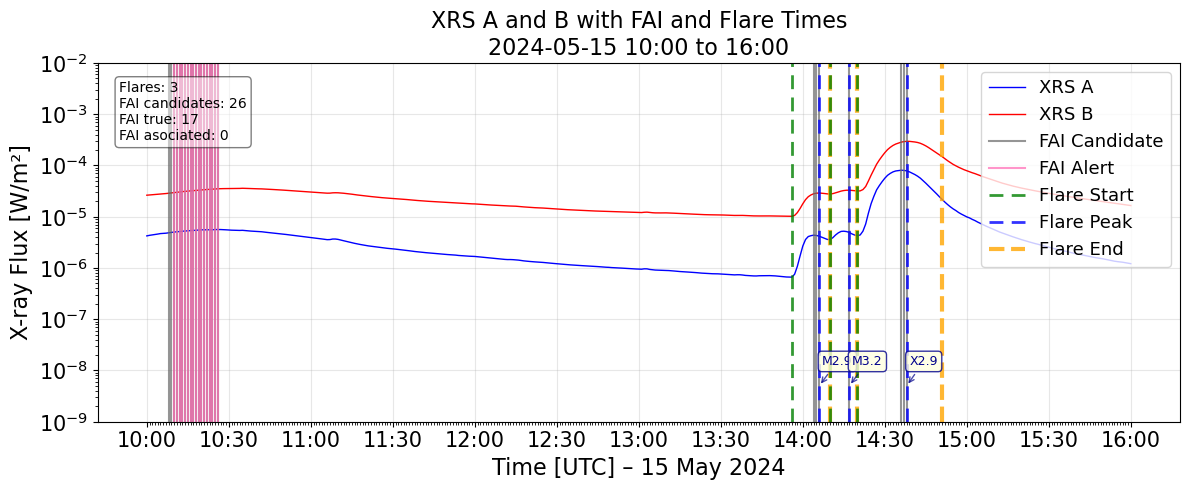

In [67]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2024-05-15 10:00:00",
                             flare_end_time="2024-05-15 16:00:00", 
                             graphics_dir=FlarebyFlare_dir,
                             freq_ticks='30min',
                             ymin=1e-9, ymax=1e-2,
                             figsize=(12, 5),
                             save_plot=False,
                             annotate_counts=True)

In [20]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2016-03-28 02:00:00'
fecha_fin    = '2016-03-28 03:00:00'

# Filtrar
df_filtrado_full_valid = df_full_valid[
    (df_full_valid['date'] >= fecha_inicio) & 
    (df_full_valid['date'] <= fecha_fin)
]

df_filtrado_full_valid

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm


In [21]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2016-03-28 02:00:00'
fecha_fin    = '2016-03-28 03:00:00'

# Filtrar
df_filtrado_fai_selected = df_fai_selected[
    (df_fai_selected['date'] >= fecha_inicio) & 
    (df_fai_selected['date'] <= fecha_fin)
]

df_filtrado_fai_selected

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,FAI_alert,FAI_true,delta_min,group_id,duration_from_start


In [22]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2016-03-28 02:10:00'
fecha_fin    = '2016-03-28 05:10:00'

# Filtrar
df_filtrado_anticipation_time = df_anticipation_time[
    (df_anticipation_time['StartTime'] >= fecha_inicio) & 
    (df_anticipation_time['StartTime'] <= fecha_fin)
]

print(df_filtrado_anticipation_time)

Empty DataFrame
Columns: [Flare_ID, StartTime, PeakTime, EndTime, Class, ClassLetter, ClassNumber, ClassGroup, Observatory, StartPeak, PeakEnd, StartEnd, FAIalerts_W, FAIalerts_WStart, FAIalerts_WPeak, FAIalerts_StartPeak, FAIalerts_PeakEnd, FAIalerts_startEnd, AnticipationStart, AnticipationPeak, Peak_to_lastFAI, Time_since_prev_flare_end, Time_since_prev_flare_peak, RelAnticipation_Peak, RelAnticipation_Start]
Index: []


Buscando datos entre: 2025-01-04 14:05:00 y 2025-01-04 16:40:00
Datos en df_plot: 156, FAI_assoc: 45, FAI_all: 49
Fulguraciones en intervalo: 0
FAI candidatos en el intervalo: 49
FAI verdaderos en el intervalo: 45
FAI asociados a flares en el intervalo: 0


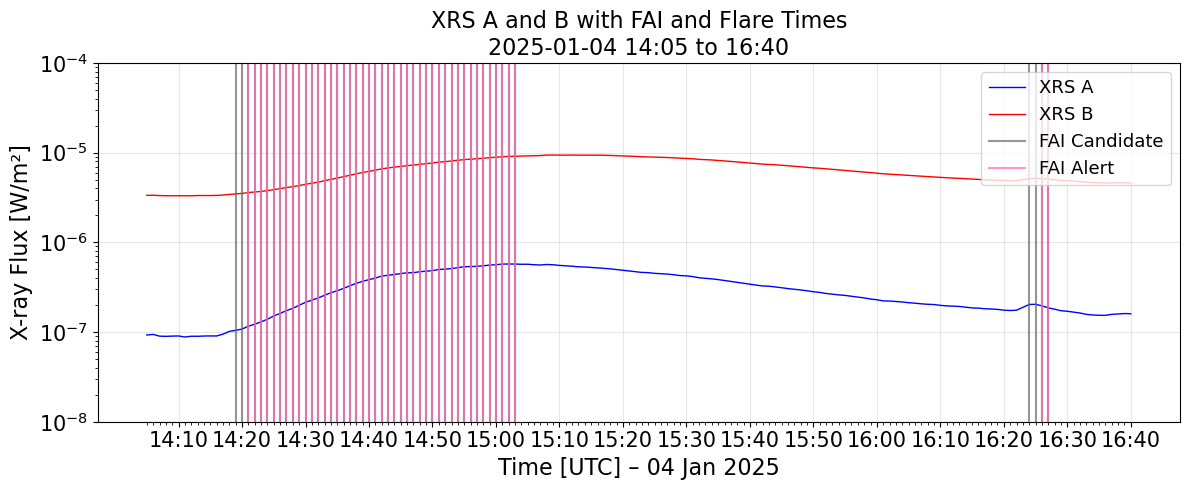

In [48]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2025-01-04 14:05:00",
                             flare_end_time="2025-01-04 16:40:00", 
                             graphics_dir=graphics_dir,
                             freq_ticks='10min',
                             ymin=1e-8, ymax=1e-4,
                             figsize=(12, 5),
                             save_plot=False)


In [47]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2025-08-28 12:10:00'
fecha_fin    = '2025-08-28 23:59:00'

# Filtrar
df_filtrado_full = df_full[
    (df_full['date'] >= fecha_inicio) & 
    (df_full['date'] <= fecha_fin)
]

df_filtrado_full

,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm


In [25]:
df_anticipation_time.sort_values(by="FAIalerts_WStart", ascending=False)[6:10]

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,PeakEnd,StartEnd,FAIalerts_W,FAIalerts_WStart,FAIalerts_WPeak,FAIalerts_StartPeak,FAIalerts_PeakEnd,FAIalerts_startEnd,AnticipationStart,AnticipationPeak,Peak_to_lastFAI,Time_since_prev_flare_end,Time_since_prev_flare_peak,RelAnticipation_Peak,RelAnticipation_Start
714,Flare_20120706_821,2012-07-06 23:01:00,2012-07-06 23:08:00,2012-07-06 23:14:00,X1.1,X,1.1,X1-4.9,GOES,7.0,6.0,13.0,14,14,14,0,0,0,21.0,28.0,11.0,NaN,NaN,4.000000,3.000000
563,Flare_20041110_635,2004-11-10 01:59:00,2004-11-10 02:13:00,2004-11-10 02:20:00,X2.5,X,2.5,X1-4.9,GOES,14.0,7.0,21.0,14,14,14,0,0,0,14.0,28.0,15.0,NaN,NaN,2.000000,1.000000
908,Flare_20141107_1045,2014-11-07 10:13:00,2014-11-07 10:22:00,2014-11-07 10:30:00,M1.0,M,1.0,M1-4.9,GOES,9.0,8.0,17.0,18,13,18,5,0,5,18.0,27.0,5.0,NaN,NaN,3.000000,2.000000
46,Flare_20001124_58,2000-11-24 07:36:00,2000-11-24 07:47:00,2000-11-24 07:56:00,C4.2,C,4.2,C1-4.9,GOES,11.0,9.0,20.0,15,13,15,2,0,2,17.0,28.0,4.0,159.0,165.0,2.545455,1.545455


In [26]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    flare_start_time="2024-10-28 03:20:00",
    flare_end_time="2024-10-28 04:50:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-3)


Buscando datos entre: 2024-10-28 03:20:00 y 2024-10-28 04:50:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 0
Datos en df_fai_interval: 0
¡ADVERTENCIA! No hay datos en df_combined para el rango 2024-10-28 03:20:00 a 2024-10-28 04:50:00


Buscando datos entre: 2014-10-26 16:40:00 y 2014-10-26 18:30:00
Datos en df_plot: 111, FAI_assoc: 29, FAI_all: 38
Fulguraciones en intervalo: 2
FAI candidatos en el intervalo: 38
FAI verdaderos en el intervalo: 29
FAI asociados a flares en el intervalo: 29


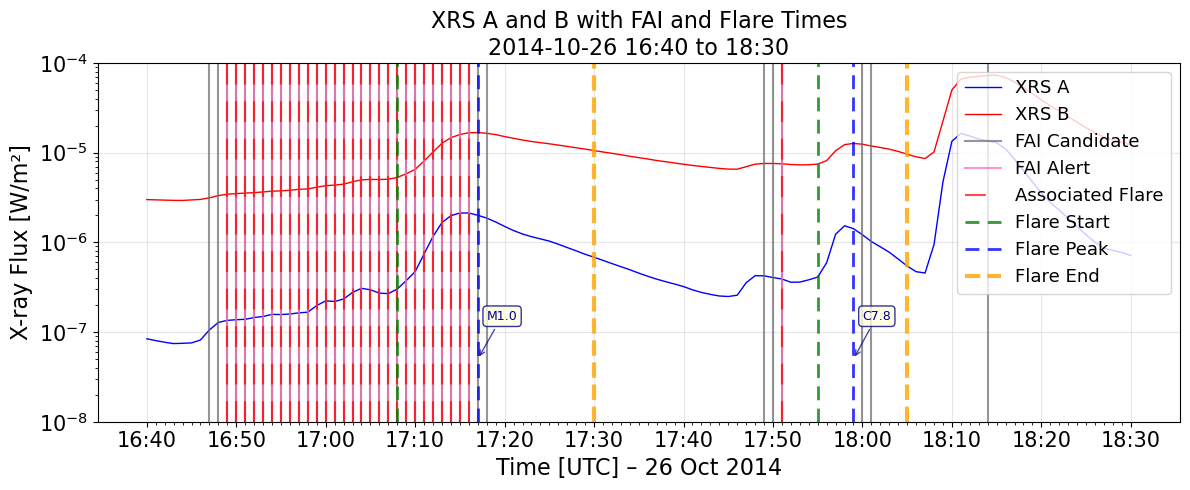

In [50]:

plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2014-10-26 16:40:00",
                             flare_end_time="2014-10-26 18:30:00", 
                             graphics_dir=graphics_dir,
                             freq_ticks='10min',
                             ymin=1e-8, ymax=1e-4,
                             figsize=(12, 5),
                             save_plot=False)

Buscando datos entre: 2001-11-04 15:00:00 y 2001-11-04 16:00:00
Datos en df_plot: 61, FAI_assoc: 24, FAI_all: 26
Fulguraciones en intervalo: 1
FAI candidatos en el intervalo: 26
FAI verdaderos en el intervalo: 24
FAI asociados a flares en el intervalo: 24


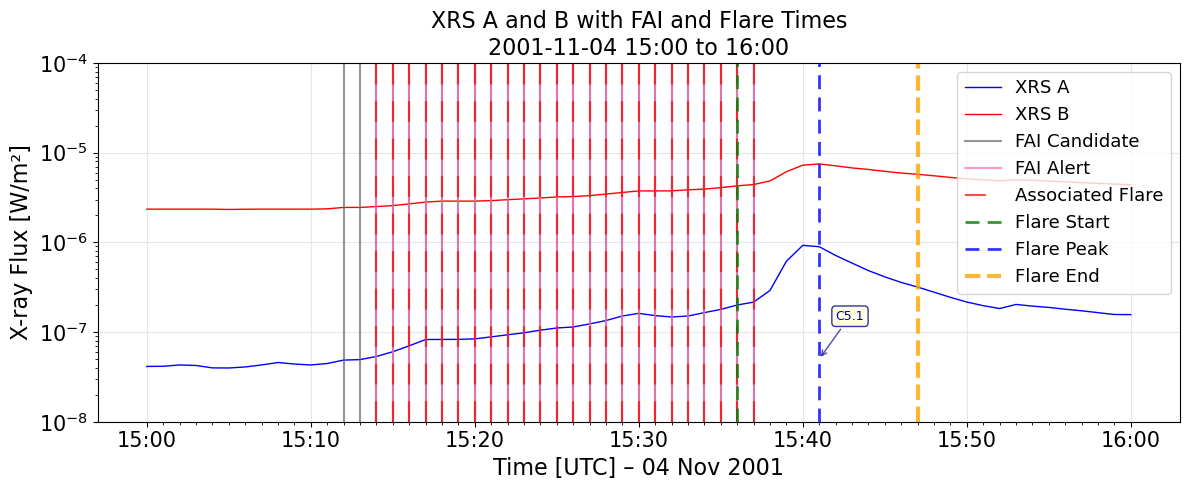

In [52]:

plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2001-11-04 15:00:00",
                             flare_end_time="2001-11-04 16:00:00", 
                             graphics_dir=graphics_dir,
                             freq_ticks='10min',
                             ymin=1e-8, ymax=1e-4,
                             figsize=(12, 5),
                             save_plot=False)

Buscando datos entre: 2025-01-04 14:11:00 y 2025-01-04 16:34:00
Datos en df_plot: 144, FAI_assoc: 45, FAI_all: 49
Fulguraciones en intervalo: 0
FAI candidatos en el intervalo: 49
FAI verdaderos en el intervalo: 45
FAI asociados a flares en el intervalo: 0


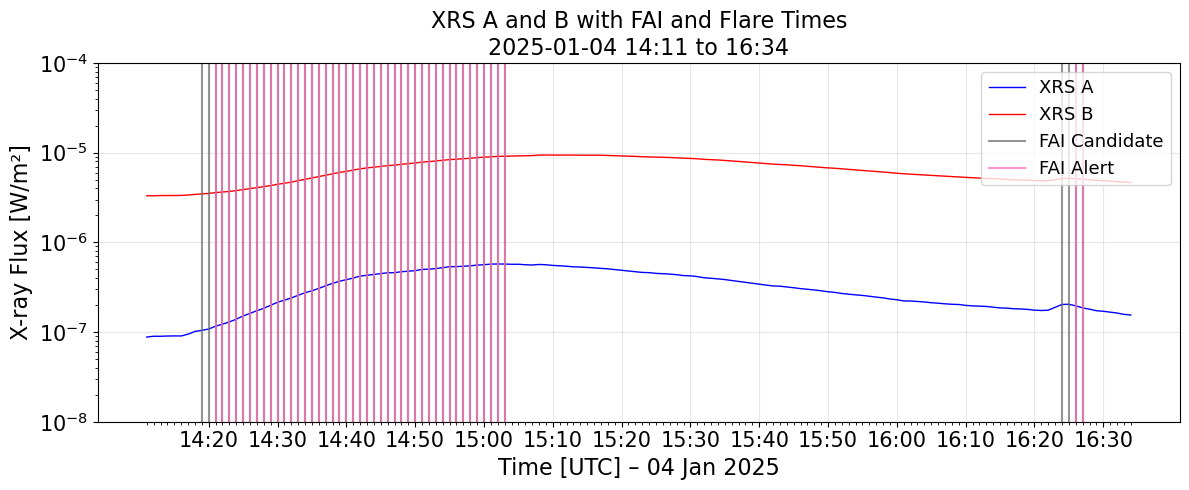

In [53]:


plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2025-01-04 14:11:00",
                             flare_end_time="2025-01-04 16:34:00", 
                             graphics_dir=graphics_dir,
                             freq_ticks='10min',
                             ymin=1e-8, ymax=1e-4,
                             figsize=(12, 5),
                             save_plot=False)

Buscando datos entre: 2000-11-26 06:10:00 y 2000-11-26 10:40:00
Datos en df_plot: 271, FAI_assoc: 67, FAI_all: 90
Fulguraciones en intervalo: 0
FAI candidatos en el intervalo: 90
FAI verdaderos en el intervalo: 67
FAI asociados a flares en el intervalo: 0


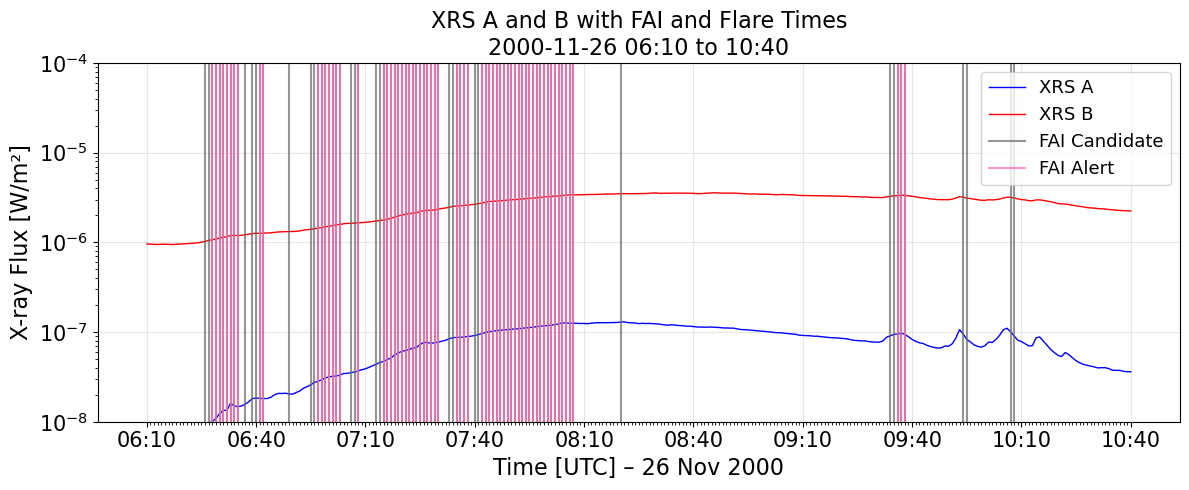

In [55]:

plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2000-11-26 06:10:00",
                             flare_end_time="2000-11-26 10:40:00", 
                             graphics_dir=graphics_dir,
                             freq_ticks='30min',
                             ymin=1e-8, ymax=1e-4,
                             figsize=(12, 5),
                             save_plot=False)


## Flares X que no tienen FAI alerts

Buscando datos entre: 2000-06-06 12:50:00 y 2000-06-06 15:45:00


Datos en df_plot: 176, FAI_assoc: 3, FAI_all: 9
Fulguraciones en intervalo: 4
FAI candidatos en el intervalo: 9
FAI verdaderos en el intervalo: 3
FAI asociados a flares en el intervalo: 3


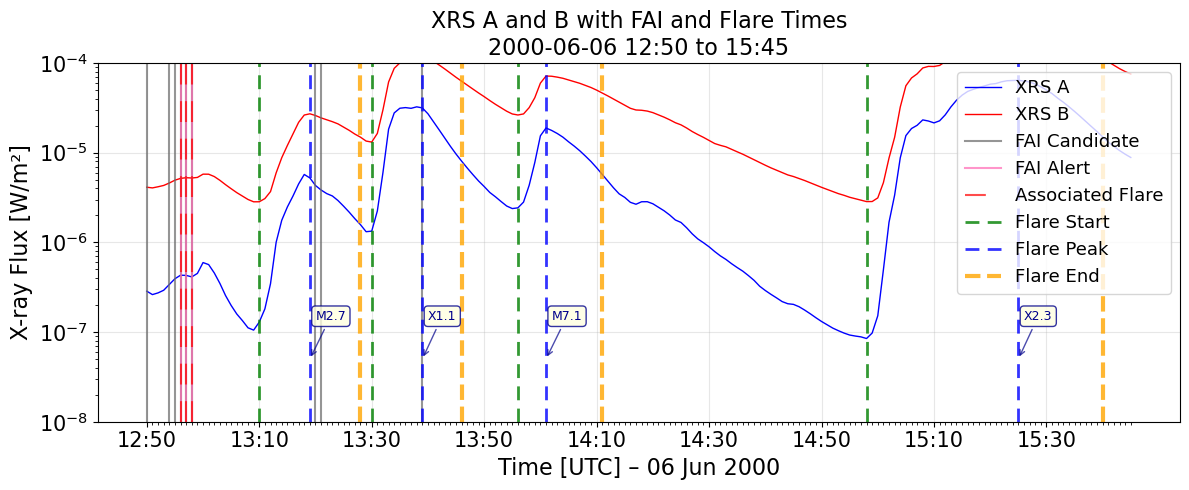

In [56]:
plot_fai_and_flare_lines(df_combined=df_full,
                             df_fai_assoc=df_fai_assoc,
                             df_fai_all=df_fai_all,
                             df_flare_data=df_flares_valid,
                             flare_start_time="2000-06-06 12:50:00",
                             flare_end_time="2000-06-06 15:45:00", 
                             graphics_dir=graphics_dir,
                             freq_ticks='20min',
                             ymin=1e-8, ymax=1e-4,
                             figsize=(12, 5),
                             save_plot=False)

In [33]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='10min',
    flare_start_time="2000-06-07 15:20:00",
    flare_end_time="2000-06-07 16:20:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-3)


Buscando datos entre: 2000-06-07 15:20:00 y 2000-06-07 16:20:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 0
Datos en df_fai_interval: 0
¡ADVERTENCIA! No hay datos en df_combined para el rango 2000-06-07 15:20:00 a 2000-06-07 16:20:00


Buscando datos entre: 2000-06-18 01:00:00 y 2000-06-18 03:20:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 141
Datos en df_fai_interval: 11
Fulguraciones encontradas en el intervalo: 1


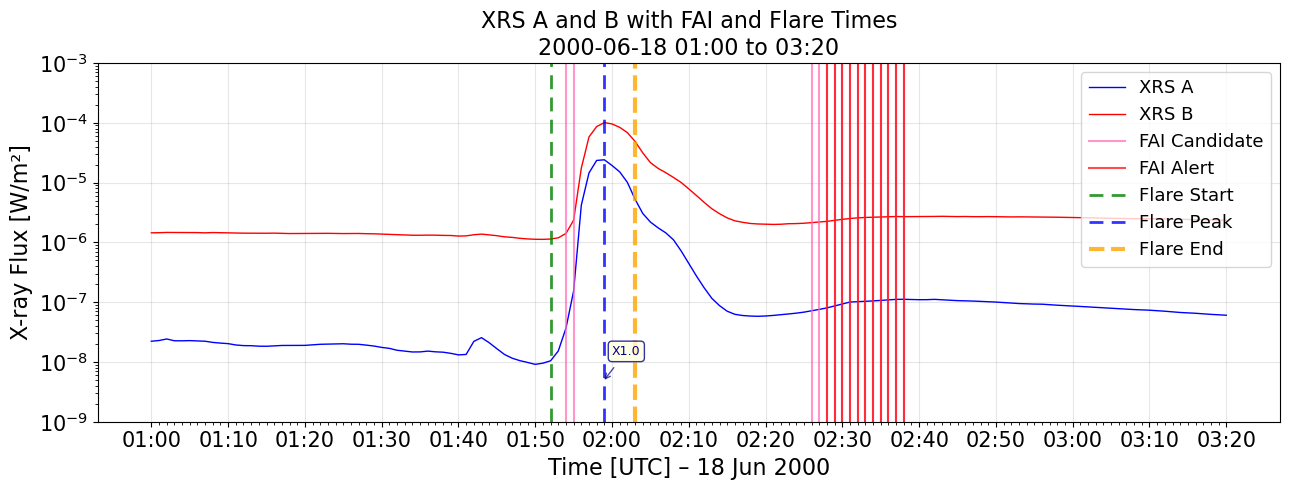

In [34]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='10min',
    flare_start_time="2000-06-18 01:00:00",
    flare_end_time="2000-06-18 03:20:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-3)


Buscando datos entre: 2000-07-14 09:30:00 y 2000-07-14 11:00:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 91
Datos en df_fai_interval: 20
Fulguraciones encontradas en el intervalo: 2


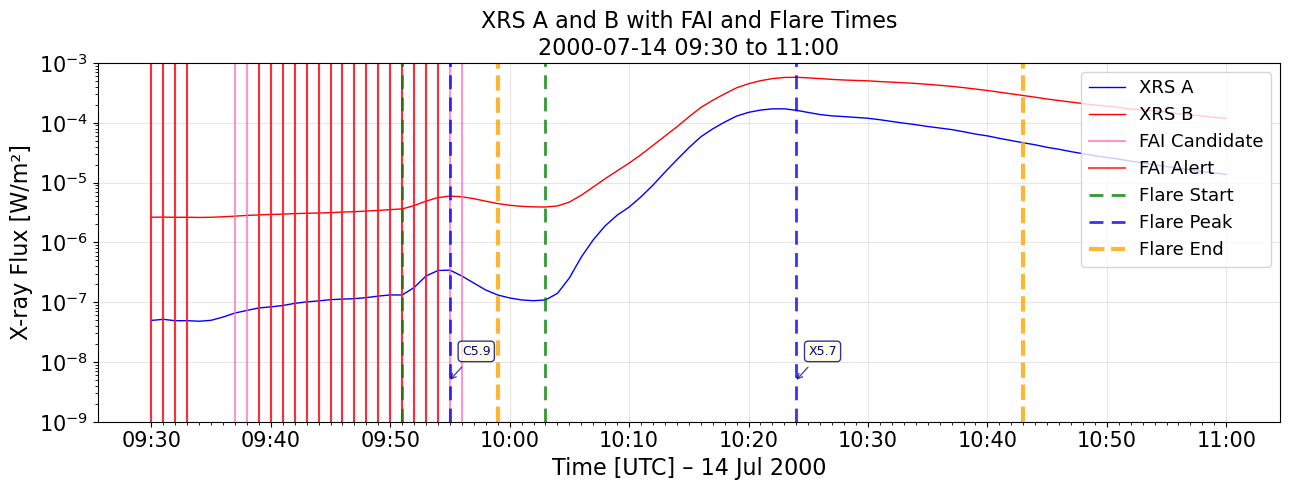

In [35]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='10min',
    flare_start_time="2000-07-14 09:30:00",
    flare_end_time="2000-07-14 11:00:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-3)


Buscando datos entre: 2001-04-02 09:00:00 y 2001-04-02 10:30:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 91
Datos en df_fai_interval: 0
Fulguraciones encontradas en el intervalo: 2


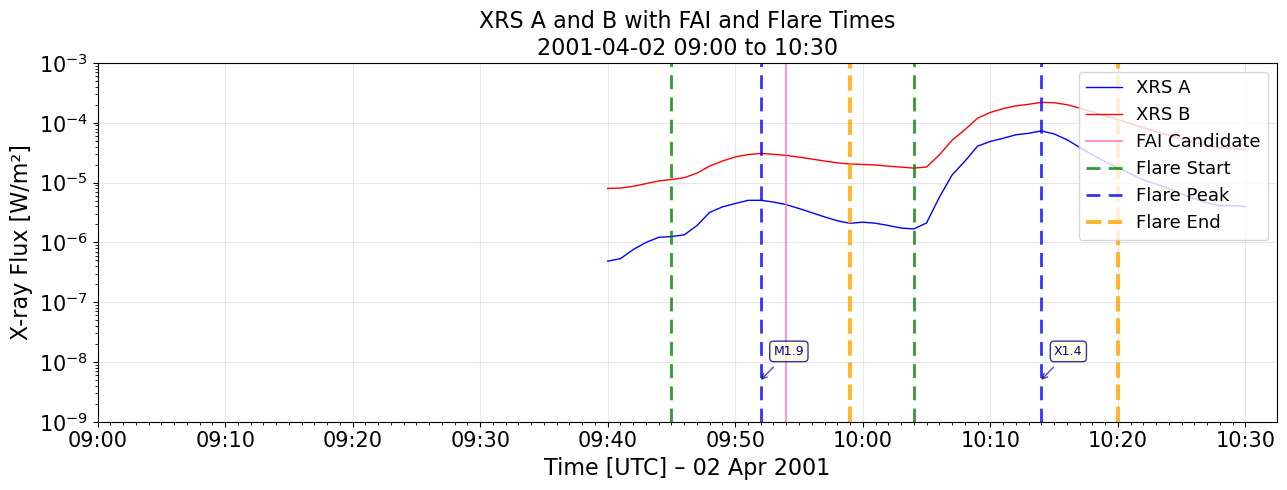

In [36]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='10min',
    flare_start_time="2001-04-02 09:00:00",
    flare_end_time="2001-04-02 10:30:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-3)

Buscando datos entre: 2001-04-02 09:00:00 y 2001-04-02 12:50:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 231
Datos en df_fai_interval: 0
Fulguraciones encontradas en el intervalo: 2


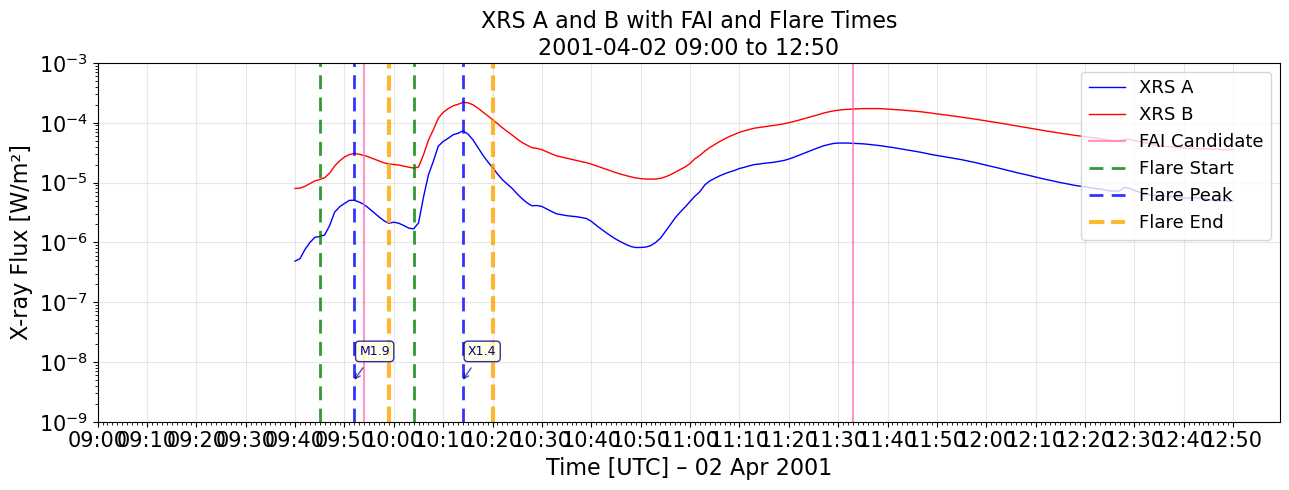

In [37]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='10min',
    flare_start_time="2001-04-02 09:00:00",
    flare_end_time="2001-04-02 12:50:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-3)

Buscando datos entre: 2000-11-24 03:20:00 y 2000-11-24 05:40:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 141
Datos en df_fai_interval: 13
Fulguraciones encontradas en el intervalo: 1


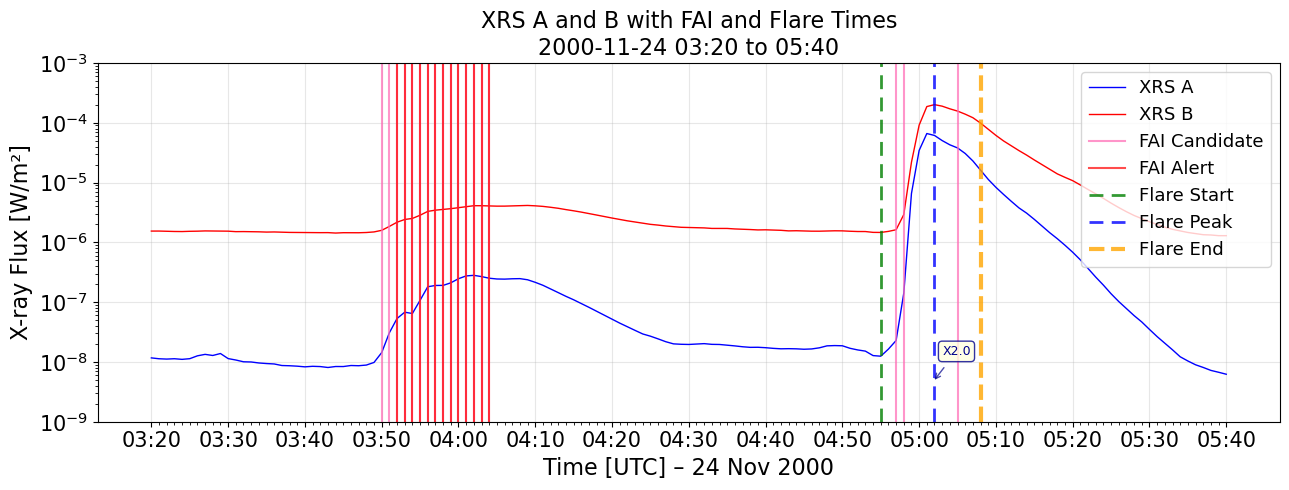

In [38]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='10min',
    flare_start_time="2000-11-24 03:20:00",
    flare_end_time="2000-11-24 05:40:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-3)

Buscando datos entre: 2001-03-29 05:30:00 y 2001-03-29 10:40:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 311
Datos en df_fai_interval: 9
Fulguraciones encontradas en el intervalo: 0


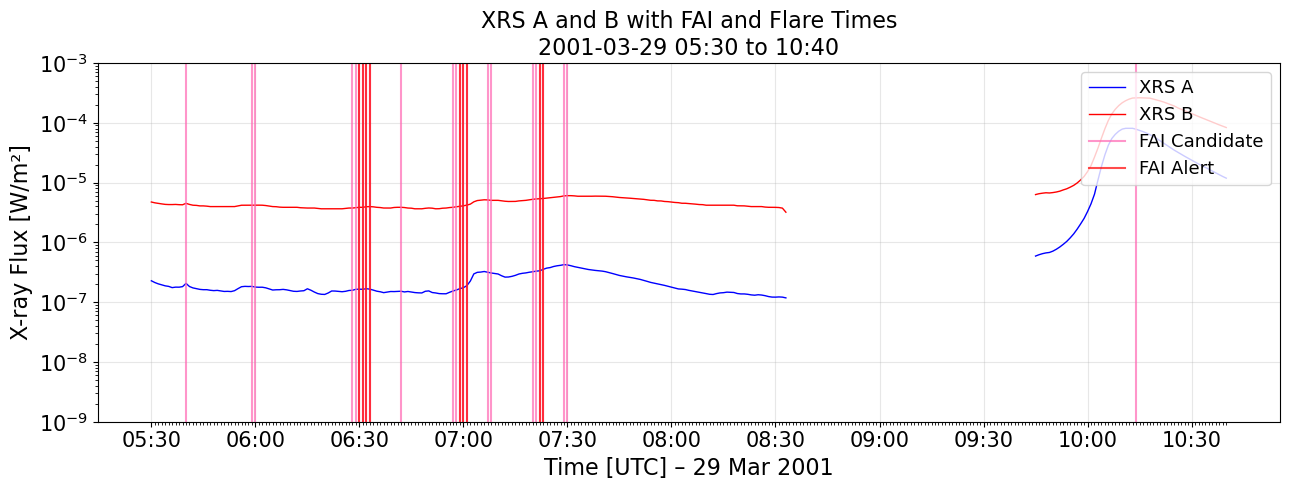

In [39]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='30min',
    flare_start_time="2001-03-29 05:30:00",
    flare_end_time="2001-03-29 10:40:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-3)


Buscando datos entre: 2001-10-22 14:30:00 y 2001-10-22 18:50:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 261
Datos en df_fai_interval: 9
Fulguraciones encontradas en el intervalo: 1


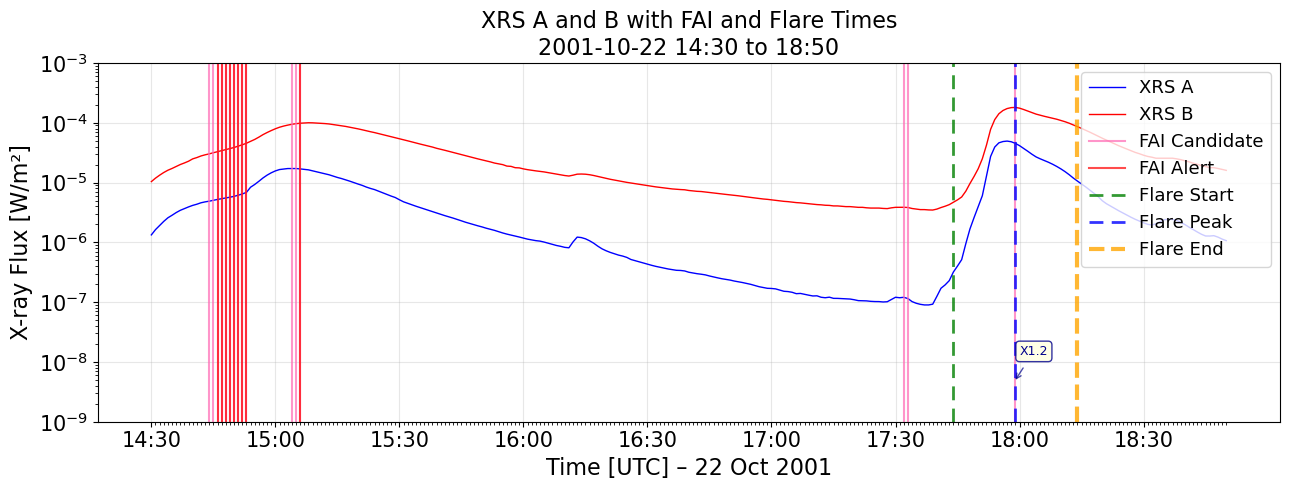

In [40]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='30min',
    flare_start_time="2001-10-22 14:30:00",
    flare_end_time="2001-10-22 18:50:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-3)




Buscando datos entre: 2001-04-15 12:10:00 y 2001-04-15 14:50:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 161
Datos en df_fai_interval: 3
Fulguraciones encontradas en el intervalo: 1


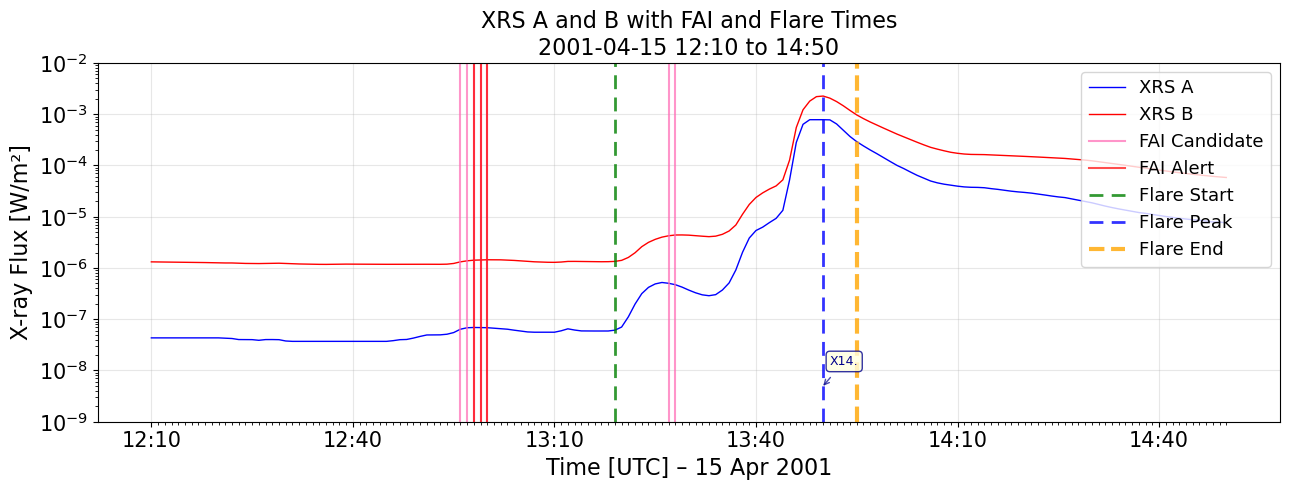

In [41]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='30min',
    flare_start_time="2001-04-15 12:10:00",
    flare_end_time="2001-04-15 14:50:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-2)


Buscando datos entre: 2001-08-25 15:00:00 y 2001-08-25 18:30:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 211
Datos en df_fai_interval: 16
Fulguraciones encontradas en el intervalo: 2


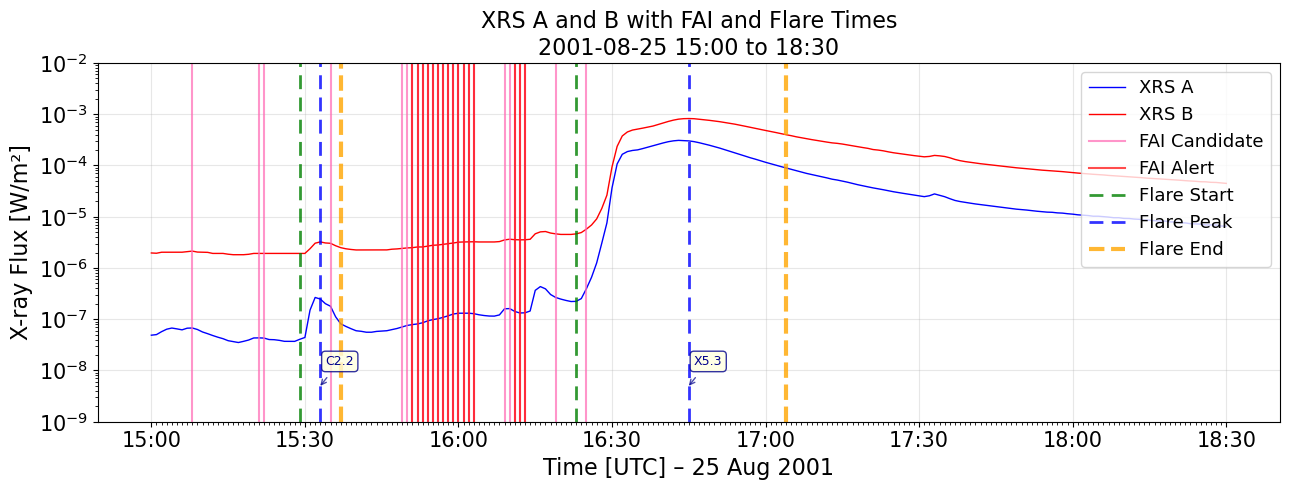

In [42]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='30min',
    flare_start_time="2001-08-25 15:00:00",
    flare_end_time="2001-08-25 18:30:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-2)



In [43]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='30min',
    flare_start_time="2025-02-23 18:30:00",
    flare_end_time="2025-02-23 10:30:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-2)

Buscando datos entre: 2025-02-23 18:30:00 y 2025-02-23 10:30:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 0
Datos en df_fai_interval: 0
¡ADVERTENCIA! No hay datos en df_combined para el rango 2025-02-23 18:30:00 a 2025-02-23 10:30:00


In [ ]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    freq_ticks='30min',
    flare_start_time="2025-06-17 21:10:00",
    flare_end_time="2025-06-17 22:30:00", 
    graphics_dir=graphics_dir,
    ymin=1e-9, ymax=1e-2)



Buscando datos entre: 2025-06-17 21:10:00 y 2025-06-17 22:30:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 81
Datos en df_fai_interval: 1
Fulguraciones encontradas en el intervalo: 1


## Observatory

In [ ]:
# Ver todos los observatorios únicos
print("Observatorios únicos:")
print(df_full_valid['observatory'].unique())

# O en formato de lista
print("\nLista de observatorios:")
print(list(df_full_valid['observatory'].unique()))

Observatorios únicos:
['GOES-16' 'GOES-10' 'GOES-15' 'GOES-14' 'GOES-13' 'GOES-18']

Lista de observatorios:
['GOES-16', 'GOES-10', 'GOES-15', 'GOES-14', 'GOES-13', 'GOES-18']


In [ ]:
# Ver observatorios con cantidad de registros
print("Conteo por observatorio:")
print(df_full_valid['observatory'].value_counts())

# Con porcentajes
print("\nPorcentajes por observatorio:")
print(df_full_valid['observatory'].value_counts(normalize=True) * 100)

Conteo por observatorio:
observatory
GOES-16    29158
GOES-10    20449
GOES-13     7298
GOES-15     6006
GOES-18     1447
GOES-14      246
Name: count, dtype: int64

Porcentajes por observatorio:
observatory
GOES-16    45.133428
GOES-10    31.652839
GOES-13    11.296514
GOES-15     9.296638
GOES-18     2.239799
GOES-14     0.380781
Name: proportion, dtype: float64


In [ ]:
# Rango de fechas general
print("=== RANGOS DE FECHAS ===")
print(f"Fecha mínima: {df_full_valid['date'].min()}")
print(f"Fecha máxima: {df_full_valid['date'].max()}")

# Por observatorio
for observatorio in df_full_valid['observatory'].unique():
    subset = df_full_valid[df_full_valid['observatory'] == observatorio]
    print(f"\n{observatorio}:")
    print(f"  Desde: {subset['date'].min()}")
    print(f"  Hasta: {subset['date'].max()}")
    print(f"  Registros: {len(subset):,}")

=== RANGOS DE FECHAS ===
Fecha mínima: 2000-06-06 00:05:00
Fecha máxima: 2025-06-19 23:52:00

GOES-16:
  Desde: 2000-06-06 00:05:00
  Hasta: 2025-03-28 23:40:00
  Registros: 29,158

GOES-10:
  Desde: 2001-03-29 01:16:00
  Hasta: 2006-12-14 22:15:00
  Registros: 20,449

GOES-15:
  Desde: 2011-02-15 00:32:00
  Hasta: 2014-11-07 23:50:00
  Registros: 6,006

GOES-14:
  Desde: 2012-10-23 00:05:00
  Hasta: 2012-10-23 23:04:00
  Registros: 246

GOES-13:
  Desde: 2013-10-25 00:05:00
  Hasta: 2015-05-05 23:56:00
  Registros: 7,298

GOES-18:
  Desde: 2025-05-13 00:15:00
  Hasta: 2025-06-19 23:52:00
  Registros: 1,447


In [ ]:
def diagnosticar_observatorios(df):
    """Función completa para diagnosticar los observatorios disponibles"""
    
    print("=== DIAGNÓSTICO DE OBSERVATORIOS ===")
    print(f"Total de registros: {len(df):,}")
    
    # Observatorios únicos
    observatorios = df['observatory'].unique()
    print(f"\n📡 Observatorios encontrados ({len(observatorios)}):")
    for i, obs in enumerate(observatorios, 1):
        print(f"  {i}. '{obs}'")
    
    # Conteo detallado
    print(f"\n📊 Conteo por observatorio:")
    conteo = df['observatory'].value_counts()
    for obs, count in conteo.items():
        porcentaje = (count / len(df)) * 100
        print(f"  '{obs}': {count:,} registros ({porcentaje:.1f}%)")
    
    # Rango de fechas por observatorio
    print(f"\n📅 Rango de fechas por observatorio:")
    for obs in observatorios:
        datos_obs = df[df['observatory'] == obs]
        fecha_min = datos_obs['date'].min()
        fecha_max = datos_obs['date'].max()
        print(f"  '{obs}': {fecha_min} a {fecha_max}")
    
    return observatorios



In [ ]:
# Ejecutar el diagnóstico
observatorios_disponibles = diagnosticar_observatorios(df_full_valid)
observatorios_disponibles

=== DIAGNÓSTICO DE OBSERVATORIOS ===
Total de registros: 64,604

📡 Observatorios encontrados (6):
  1. 'GOES-16'
  2. 'GOES-10'
  3. 'GOES-15'
  4. 'GOES-14'
  5. 'GOES-13'
  6. 'GOES-18'

📊 Conteo por observatorio:
  'GOES-16': 29,158 registros (45.1%)
  'GOES-10': 20,449 registros (31.7%)
  'GOES-13': 7,298 registros (11.3%)
  'GOES-15': 6,006 registros (9.3%)
  'GOES-18': 1,447 registros (2.2%)
  'GOES-14': 246 registros (0.4%)

📅 Rango de fechas por observatorio:
  'GOES-16': 2000-06-06 00:05:00 a 2025-03-28 23:40:00
  'GOES-10': 2001-03-29 01:16:00 a 2006-12-14 22:15:00
  'GOES-15': 2011-02-15 00:32:00 a 2014-11-07 23:50:00
  'GOES-14': 2012-10-23 00:05:00 a 2012-10-23 23:04:00
  'GOES-13': 2013-10-25 00:05:00 a 2015-05-05 23:56:00
  'GOES-18': 2025-05-13 00:15:00 a 2025-06-19 23:52:00


array(['GOES-16', 'GOES-10', 'GOES-15', 'GOES-14', 'GOES-13', 'GOES-18'],
      dtype=object)

In [ ]:
# Buscar observatorios que contengan "GOES"
print("Observatorios que contienen 'GOES':")
goes_observatories = [obs for obs in df_full_valid['observatory'].unique() if 'GOES' in obs.upper()]
print(goes_observatories)

# Buscar observatorios que contengan "16" (por si es GOES-16, GOES16, etc)
print("\nObservatorios que contienen '16':")
obs_16 = [obs for obs in df_full_valid['observatory'].unique() if '16' in obs]
print(obs_16)

Observatorios que contienen 'GOES':
['GOES-16', 'GOES-10', 'GOES-15', 'GOES-14', 'GOES-13', 'GOES-18']

Observatorios que contienen '16':
['GOES-16']


In [ ]:
# Para un conteo rápido
observatorio = 'GOES-18'
inicio = pd.Timestamp('2025-08-28 14:00:00')
fin = pd.Timestamp('2025-08-28 16:00:00')

conteo = len(df_full_valid[
    (df_full_valid['observatory'] == observatorio) &
    (df_full_valid['date'] >= inicio) &
    (df_full_valid['date'] <= fin)
])

print(f"'{observatorio}' tiene {conteo} registros entre {inicio} y {fin}")

'GOES-18' tiene 0 registros entre 2025-08-28 14:00:00 y 2025-08-28 16:00:00


In [ ]:
def contar_registros_observatorio(df, observatorio, fecha_inicio, fecha_fin):
    """
    Cuenta registros de un observatorio específico entre fechas dadas
    """
    # Aplicar filtros
    filtrado = df[
        (df['observatory'] == observatorio) &
        (df['date'] >= fecha_inicio) &
        (df['date'] <= fecha_fin)
    ]
    
    print(f"🔍 Observatorio: '{observatorio}'")
    print(f"📅 Rango: {fecha_inicio} a {fecha_fin}")
    print(f"📊 Registros encontrados: {len(filtrado):,}")
    
    if len(filtrado) > 0:
        print(f"📈 Primer registro: {filtrado['date'].min()}")
        print(f"📉 Último registro: {filtrado['date'].max()}")
        print(f"⏱️  Duración: {(filtrado['date'].max() - filtrado['date'].min())}")
    
    return len(filtrado)



In [ ]:
# Ejemplo de uso
contar_registros_observatorio(
    df=df_full_valid,
    observatorio='GOES-16',  # Cambia por el observatorio que necesites
    fecha_inicio=pd.Timestamp('1980-01-05 00:13:00'),
    fecha_fin=pd.Timestamp('2016-01-01 00:00:00')
)

🔍 Observatorio: 'GOES-16'
📅 Rango: 1980-01-05 00:13:00 a 2016-01-01 00:00:00
📊 Registros encontrados: 3,599
📈 Primer registro: 2000-06-06 00:05:00
📉 Último registro: 2000-11-26 23:59:00
⏱️  Duración: 173 days 23:54:00


3599

In [ ]:
def analizar_observatorio_rango(df, observatorio, fecha_inicio, fecha_fin):
    """
    Análisis detallado de un observatorio en un rango de fechas
    """
    print("=" * 60)
    print(f"ANÁLISIS DETALLADO - OBSERVATORIO: {observatorio}")
    print("=" * 60)
    
    # Aplicar filtros
    mascara = (
        (df['observatory'] == observatorio) &
        (df['date'] >= fecha_inicio) &
        (df['date'] <= fecha_fin)
    )
    
    datos_filtrados = df[mascara]
    total_registros = len(datos_filtrados)
    
    print(f"📅 Rango solicitado: {fecha_inicio} a {fecha_fin}")
    print(f"📊 Total de registros: {total_registros:,}")
    
    if total_registros == 0:
        print("❌ No se encontraron registros en este rango")
        return None
    
    # Información temporal
    print(f"\n📈 Primer registro: {datos_filtrados['date'].min()}")
    print(f"📉 Último registro: {datos_filtrados['date'].max()}")
    duracion = datos_filtrados['date'].max() - datos_filtrados['date'].min()
    print(f"⏱️  Duración total: {duracion}")
    
    # Análisis de datos faltantes
    print(f"\n🔍 Calidad de datos:")
    for col in ['T_cor', 'EM_cor', 'T_phot', 'EM_phot']:
        if col in df.columns:
            no_nulos = datos_filtrados[col].notna().sum()
            porcentaje = (no_nulos / total_registros) * 100
            print(f"   {col}: {no_nulos}/{total_registros} ({porcentaje:.1f}%) no nulos")
    
    # Estadísticas básicas
    print(f"\n📊 Estadísticas (datos no nulos):")
    for col in ['T_cor', 'EM_cor']:
        if col in df.columns and datos_filtrados[col].notna().sum() > 0:
            datos_validos = datos_filtrados[col].dropna()
            print(f"   {col}:")
            print(f"     Mín: {datos_validos.min():.2e}")
            print(f"     Máx: {datos_validos.max():.2e}")
            print(f"     Promedio: {datos_validos.mean():.2e}")
    
    return datos_filtrados



In [ ]:
# Ejemplo de uso
analizar_observatorio_rango(
    df=df_full_valid,
    observatorio='GOES-16',
    fecha_inicio=pd.Timestamp('1980-01-05 00:13:00'),
    fecha_fin=pd.Timestamp('2016-01-01 00:00:00')
)

ANÁLISIS DETALLADO - OBSERVATORIO: GOES-16
📅 Rango solicitado: 1980-01-05 00:13:00 a 2016-01-01 00:00:00
📊 Total de registros: 3,599

📈 Primer registro: 2000-06-06 00:05:00
📉 Último registro: 2000-11-26 23:59:00
⏱️  Duración total: 173 days 23:54:00

🔍 Calidad de datos:
   T_cor: 3599/3599 (100.0%) no nulos
   EM_cor: 3599/3599 (100.0%) no nulos
   T_phot: 3599/3599 (100.0%) no nulos
   EM_phot: 3599/3599 (100.0%) no nulos

📊 Estadísticas (datos no nulos):
   T_cor:
     Mín: 1.90e+00
     Máx: 7.87e+01
     Promedio: 1.16e+01
   EM_cor:
     Mín: 5.79e+45
     Máx: 2.48e+50
     Promedio: 2.08e+48


,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
0,GOES_0,2000-06-06 00:05:00,GOES-16,1.220925e-08,8.860234e-07,3.788372e-09,3.142395e-08,12.571802,1.839645e+46,11.630426,4.512600e+46,0.001840,0.004513
1,GOES_1,2000-06-06 00:06:00,GOES-16,1.346536e-08,8.977652e-07,5.258025e-09,4.601407e-08,12.297073,2.748919e+46,11.315239,6.866820e+46,0.002749,0.006867
2,GOES_2,2000-06-06 00:07:00,GOES-16,1.536368e-08,9.099479e-07,7.282076e-09,5.697751e-08,12.875831,3.267130e+46,11.983715,7.855587e+46,0.003267,0.007856
3,GOES_3,2000-06-06 00:08:00,GOES-16,1.425506e-08,9.134990e-07,4.896752e-09,5.101930e-08,11.426795,3.280485e+46,10.346220,8.692047e+46,0.003280,0.008692
4,GOES_4,2000-06-06 00:09:00,GOES-16,1.343720e-08,9.078860e-07,2.276667e-09,3.068232e-08,10.207486,2.251486e+46,9.086091,6.454625e+46,0.002251,0.006455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,GOES_3594,2000-11-26 23:21:00,GOES-16,1.706188e-08,1.094779e-06,4.933877e-09,6.713685e-08,10.163755,4.953455e+46,9.042846,1.423967e+47,0.004953,0.014240
3595,GOES_3595,2000-11-26 23:22:00,GOES-16,1.552415e-08,1.070242e-06,2.110942e-09,3.201831e-08,9.681431,2.518911e+46,8.573797,7.458897e+46,0.002519,0.007459
3596,GOES_3596,2000-11-26 23:57:00,GOES-16,1.495193e-08,9.728188e-07,2.980438e-09,2.960627e-08,11.661427,1.863526e+46,10.602115,4.859970e+46,0.001864,0.004860
3597,GOES_3597,2000-11-26 23:58:00,GOES-16,1.974207e-08,1.026847e-06,7.741527e-09,7.393601e-08,11.856570,4.576119e+46,10.818334,1.177623e+47,0.004576,0.011776


In [ ]:
def comparar_observatorios_rango(df, observatorios, fecha_inicio, fecha_fin):
    """
    Compara múltiples observatorios en el mismo rango de fechas
    """
    print("COMPARACIÓN DE OBSERVATORIOS")
    print(f"Rango: {fecha_inicio} a {fecha_fin}")
    print("-" * 50)
    
    resultados = {}
    
    for obs in observatorios:
        mascara = (
            (df['observatory'] == obs) &
            (df['date'] >= fecha_inicio) &
            (df['date'] <= fecha_fin)
        )
        
        datos_obs = df[mascara]
        total = len(datos_obs)
        
        resultados[obs] = {
            'registros': total,
            'datos': datos_obs
        }
        
        print(f"🔭 {obs}: {total:,} registros")
        
        if total > 0:
            # Calcular frecuencia aproximada (registros por hora)
            duracion_horas = (fecha_fin - fecha_inicio).total_seconds() / 3600
            freq_por_hora = total / duracion_horas if duracion_horas > 0 else 0
            print(f"   📏 Frecuencia: ~{freq_por_hora:.1f} registros/hora")
    
    return resultados


In [ ]:

# Ejemplo con múltiples observatorios
observatorios_interes = ['GOES-16', 'GOES-10', 'GOES-12', 'GOES-11', 'GOES-14', 'GOES-15', 'GOES-13', 'GOES-18']  # Ajusta a los que tengas
resultados = comparar_observatorios_rango(
    df=df_full_valid,
    observatorios=observatorios_interes,
    fecha_inicio=pd.Timestamp('1980-01-05 00:13:00'),
    fecha_fin=pd.Timestamp('2001-02-15 21:01:00')
)

COMPARACIÓN DE OBSERVATORIOS
Rango: 1980-01-05 00:13:00 a 2001-02-15 21:01:00
--------------------------------------------------
🔭 GOES-16: 3,599 registros
   📏 Frecuencia: ~0.0 registros/hora
🔭 GOES-10: 0 registros
🔭 GOES-12: 0 registros
🔭 GOES-11: 0 registros
🔭 GOES-14: 0 registros
🔭 GOES-15: 0 registros
🔭 GOES-13: 0 registros
🔭 GOES-18: 0 registros


# pruebas

        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np
        import pandas as pd
        from datetime import datetime

        # Configuración inicial
        plt.style.use('default')
        sns.set_palette("husl")

        # 1. DISTRIBUCIÓN DE CLASES DE FULGURACIONES
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        df_flares_valid['Class'].value_counts().plot(kind='bar')
        plt.title('Distribución de Clases de Fulguraciones')
        plt.xlabel('Clase')
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        # Si quieres ver la distribución logarítmica
        class_counts = df_flares_valid['Class'].value_counts()
        plt.bar(range(len(class_counts)), class_counts.values)
        plt.yscale('log')
        plt.title('Distribución (Escala Logarítmica)')
        plt.xlabel('Clase')
        plt.xticks(range(len(class_counts)), class_counts.index, rotation=45)

        plt.tight_layout()
        plt.show()

        # 2. TIEMPOS DE ANTICIPACIÓN
        plt.figure(figsize=(15, 10))

        # Anticipation Start
        plt.subplot(2, 2, 1)
        plt.hist(df_anticipation_time['AnticipationStart'].dropna(), bins=50, alpha=0.7)
        plt.title('Distribución de Tiempo de Anticipación (Start)')
        plt.xlabel('Tiempo (minutos)')
        plt.ylabel('Frecuencia')

        # Anticipation Peak
        plt.subplot(2, 2, 2)
        plt.hist(df_anticipation_time['AnticipationPeak'].dropna(), bins=50, alpha=0.7)
        plt.title('Distribución de Tiempo de Anticipación (Peak)')
        plt.xlabel('Tiempo (minutos)')
        plt.ylabel('Frecuencia')

        # Peak to last FAI
        plt.subplot(2, 2, 3)
        plt.hist(df_anticipation_time['Peak_to_lastFAI'].dropna(), bins=50, alpha=0.7)
        plt.title('Tiempo desde Peak hasta último FAI')
        plt.xlabel('Tiempo (minutos)')
        plt.ylabel('Frecuencia')

        # Time since previous flare
        plt.subplot(2, 2, 4)
        plt.hist(df_anticipation_time['Time_since_prev_flare'].dropna(), bins=50, alpha=0.7)
        plt.title('Tiempo desde Fulguración Anterior')
        plt.xlabel('Tiempo (minutos)')
        plt.ylabel('Frecuencia')

        plt.tight_layout()
        plt.show()

        # 3. ANÁLISIS POR CLASE DE FULGURACIÓN
        plt.figure(figsize=(15, 8))

        # Tiempos de anticipación por clase
        plt.subplot(2, 3, 1)
        sns.boxplot(data=df_anticipation_time, x='Class', y='AnticipationStart')
        plt.title('Anticipation Start por Clase')
        plt.xticks(rotation=45)

        plt.subplot(2, 3, 2)
        sns.boxplot(data=df_anticipation_time, x='Class', y='AnticipationPeak')
        plt.title('Anticipation Peak por Clase')
        plt.xticks(rotation=45)

        plt.subplot(2, 3, 3)
        sns.boxplot(data=df_anticipation_time, x='Class', y='StartPeak')
        plt.title('Duración Start-Peak por Clase')
        plt.xticks(rotation=45)

        plt.subplot(2, 3, 4)
        sns.boxplot(data=df_anticipation_time, x='Class', y='PeakEnd')
        plt.title('Duración Peak-End por Clase')
        plt.xticks(rotation=45)

        plt.subplot(2, 3, 5)
        sns.boxplot(data=df_anticipation_time, x='Class', y='StartEnd')
        plt.title('Duración Total por Clase')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # 4. DISTRIBUCIÓN DE PARÁMETROS FÍSICOS
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 3, 1)
        plt.hist(df_full_valid['T_cor'], bins=100, alpha=0.7)
        plt.title('Distribución de Temperatura Coronal')
        plt.xlabel('Temperatura (K)')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 2)
        plt.hist(df_full_valid['EM_cor'], bins=100, alpha=0.7)
        plt.title('Distribución de Medida de Emisión Coronal')
        plt.xlabel('EM')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 3)
        plt.hist(df_full_valid['xrsa'], bins=100, alpha=0.7)
        plt.title('Distribución de XRSA')
        plt.xlabel('XRSA')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 4)
        plt.hist(df_full_valid['xrsb'], bins=100, alpha=0.7)
        plt.title('Distribución de XRSB')
        plt.xlabel('XRSB')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 5)
        plt.hist(df_full_valid['T_phot'], bins=100, alpha=0.7)
        plt.title('Distribución de Temperatura Fotósferica')
        plt.xlabel('Temperatura (K)')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 6)
        plt.hist(df_full_valid['EM_phot'], bins=100, alpha=0.7)
        plt.title('Distribución de Medida de Emisión Fotósferica')
        plt.xlabel('EM')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.tight_layout()
        plt.show()

        # 5. ALERTAS FAI POR FULGURACIÓN
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        sns.scatterplot(data=df_anticipation_time, x='FAIalerts_W', y='AnticipationStart', hue='Class')
        plt.title('Número de Alertas FAI vs Tiempo de Anticipación')
        plt.xlabel('Número de Alertas FAI')
        plt.ylabel('Tiempo de Anticipación (min)')

        plt.subplot(2, 2, 2)
        sns.boxplot(data=df_anticipation_time, x='Class', y='FAIalerts_W')
        plt.title('Alertas FAI por Clase de Fulguraciones')
        plt.xticks(rotation=45)

        plt.subplot(2, 2, 3)
        # Relación entre parámetros físicos y tiempo de anticipación
        # Primero necesitamos unir los dataframes
        df_merged = pd.merge(df_anticipation_time, df_full_valid, 
                            left_on=['StartTime', 'Observatory'], 
                            right_on=['date', 'observatory'], 
                            how='left')

        if not df_merged.empty:
            plt.scatter(df_merged['T_cor'], df_merged['AnticipationStart'], alpha=0.5)
            plt.title('Temperatura Coronal vs Tiempo de Anticipación')
            plt.xlabel('Temperatura Coronal (K)')
            plt.ylabel('Tiempo de Anticipación (min)')
            plt.yscale('log')
            plt.xscale('log')

        plt.subplot(2, 2, 4)
        if not df_merged.empty:
            plt.scatter(df_merged['EM_cor'], df_merged['AnticipationStart'], alpha=0.5)
            plt.title('Medida de Emisión vs Tiempo de Anticipación')
            plt.xlabel('EM Coronal')
            plt.ylabel('Tiempo de Anticipación (min)')
            plt.yscale('log')
            plt.xscale('log')

        plt.tight_layout()
        plt.show()

        # 6. ANÁLISIS TEMPORAL
        # Convertir a datetime si no lo están
        df_flares_valid['PeakTime_dt'] = pd.to_datetime(df_flares_valid['PeakTime'])
        df_anticipation_time['PeakTime_dt'] = pd.to_datetime(df_anticipation_time['PeakTime'])

        plt.figure(figsize=(15, 10))

        # Fulguraciones por mes
        plt.subplot(2, 2, 1)
        df_flares_valid['Month'] = df_flares_valid['PeakTime_dt'].dt.month
        monthly_flares = df_flares_valid.groupby('Month').size()
        plt.bar(monthly_flares.index, monthly_flares.values)
        plt.title('Fulguraciones por Mes')
        plt.xlabel('Mes')
        plt.ylabel('Número de Fulguraciones')

        # Fulguraciones por año
        plt.subplot(2, 2, 2)
        df_flares_valid['Year'] = df_flares_valid['PeakTime_dt'].dt.year
        yearly_flares = df_flares_valid.groupby('Year').size()
        plt.bar(yearly_flares.index, yearly_flares.values)
        plt.title('Fulguraciones por Año')
        plt.xlabel('Año')
        plt.ylabel('Número de Fulguraciones')
        plt.xticks(rotation=45)

        # Tiempo de anticipación por año
        plt.subplot(2, 2, 3)
        df_anticipation_time['Year'] = df_anticipation_time['PeakTime_dt'].dt.year
        anticipation_by_year = df_anticipation_time.groupby('Year')['AnticipationStart'].mean()
        plt.plot(anticipation_by_year.index, anticipation_by_year.values, marker='o')
        plt.title('Tiempo Medio de Anticipación por Año')
        plt.xlabel('Año')
        plt.ylabel('Tiempo Medio (min)')
        plt.xticks(rotation=45)

        # Alertas FAI por año
        plt.subplot(2, 2, 4)
        fai_by_year = df_anticipation_time.groupby('Year')['FAIalerts_W'].mean()
        plt.plot(fai_by_year.index, fai_by_year.values, marker='o', color='red')
        plt.title('Alertas FAI Promedio por Año')
        plt.xlabel('Año')
        plt.ylabel('Número Promedio de Alertas FAI')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # 7. MATRIZ DE CORRELACIÓN (para variables numéricas)
        plt.figure(figsize=(12, 8))

        # Seleccionar solo columnas numéricas para la correlación
        numeric_cols = df_anticipation_time.select_dtypes(include=[np.number]).columns
        correlation_matrix = df_anticipation_time[numeric_cols].corr()

        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                    fmt='.2f', linewidths=0.5)
        plt.title('Matriz de Correlación - Variables de Anticipación')
        plt.tight_layout()
        plt.show()